# Import Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Plotly visualizations
from plotly import tools
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# Display properties
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
from IPython.display import display, HTML

# Date
import datetime
from datetime import date, timedelta


# Maps
from math import pi

import pickle 

from sklearn.preprocessing import StandardScaler

In [2]:
#Sklearn packages

# Import required packages for pre and post processing
from sklearn.preprocessing import normalize

# Perform the necessary imports
from scipy.cluster.hierarchy import linkage, dendrogram



# Call Pickle

In [3]:
with open('fifa_processed.pkl', 'rb') as f:
    fifa = pickle.load(f)


In [4]:
with open('predictors_processed.pkl', 'rb') as f:
    predictors = pickle.load(f)


In [5]:
pd.__version__

'0.25.1'

---

# Models are being used in this part:

1. SVM_ONE CLASS
2. ISOLATION FOREST
3. LOCAL OUTLIER FACTOR


---

# Anomoly_Detection

## STEP 1: Save another dataset for anomaly detection named 'predictors_ad' as pickle
Keep 'ID' and 'Value' before dropping 'Wage', 'Release Clause', 'Club', 'Name' from fifa datat set

In [147]:
fifa

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,Club_Reputation,Attack_WR,Defense_WR,Position_Group,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Continent,anomaly
0,0,L. Messi,31,Argentina,94,94,FC Barcelona,110500000.0,565000.0,2202,0,5.0,4.0,4.0,Lean,1,RF,10.0,5297,0,3,170,159,88,88,88,92,93,93,93,92,93,93,93,91,84,84,84,91,64,61,61,61,64,59,47,47,47,59,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,226500000.0,2.242424,Medium,Medium,Forward,2,85.0,93.4,91.6,75.6,71.500000,29.000000,10.8,0,South America,-1
1,1,Cristiano Ronaldo,33,Portugal,94,94,Juventus,77000000.0,405000.0,2228,1,5.0,4.0,5.0,Normal,1,ST,7.0,175,0,4,188,183,91,91,91,89,90,90,90,89,88,88,88,88,81,81,81,88,65,61,61,61,65,61,53,53,53,61,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,127100000.0,2.520000,High,Low,Forward,3,87.0,83.2,86.6,90.0,74.833333,27.333333,11.6,0,Europe,-1
2,2,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,118500000.0,290000.0,2143,1,5.0,5.0,5.0,Lean,1,LW,10.0,516,0,4,175,150,84,84,84,89,89,89,89,89,89,89,89,88,81,81,81,88,65,60,60,60,65,60,47,47,47,60,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,228100000.0,2.233333,High,Medium,Forward,3,79.2,88.8,91.6,70.6,73.833333,28.000000,11.8,1,South America,-1
3,3,De Gea,27,Spain,91,93,Manchester United,72000000.0,260000.0,1471,1,4.0,3.0,1.0,Lean,1,GK,1.0,2741,0,2,193,168,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,138600000.0,2.090909,Medium,Medium,GoalKeeper,0,22.8,30.2,61.6,43.4,42.666667,16.333333,88.8,2,Europe,-1
4,4,K. De Bruyne,27,Belgium,91,92,Manchester City,102000000.0,355000.0,2281,1,4.0,5.0,4.0,Normal,1,RCM,7.0,1220,0,5,180,154,82,82,82,87,87,87,87,87,88,88,88,88,87,87,87,88,77,77,77,77,77,73,66,66,66,73,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,196400000.0,2.090909,High,High,Midfielder,3,80.8,87.2,80.2,82.0,80.833333,59.000000,11.2,1,Europe,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18154,18202,J. Lundstram,19,England,47,65,Crewe Alexandra,60000.0,1000.0,1307,1,1.0,2.0,2.0,Lean,0,CM,22.0,608,0,1,175,134,42,42,42,44,44,44,44,44,45,45,45,44,45,45,45,44,44,45,45,45,44,45,45,45,45,45,34.0,38.0,40.0,49.0,25.0,42.0,30.0,34.0,45.0,43.0,54.0,57.0,60.0,49.0,76.0,43.0,55.0,40.0,47.0,38.0,46.0,46.0,39.0,52.0,43.0,45.0,40.0,48.0,47.0,10.0,13.0,7.0,8.0,9.0,143000.0,1.035714,Medium,Medium,Midfielder,2,3

In [148]:
#DROP these columns first
#drop_cols = ['Name','Nationality','Club','Wage','Value','Release Clause']
numeric_cols = list(fifa.dtypes[(fifa.dtypes == 'float64')|(fifa.dtypes == 'int64')].index)

#Dummy Predictors
fifa_dumm_cols = fifa.loc[:, ['Position', 'Continent', 'Position_Group']]

#Ordinal Predictors
fifa_ordinal_cols = fifa.loc[:, ['Body Type', 'Attack_WR', 'Defense_WR']]

#Numerical Predictors
fifa_numeric_cols = fifa[numeric_cols]
fifa_numeric_cols = fifa_numeric_cols.drop(['Wage','Release Clause'], axis = 1)

In [149]:
#Getting dummy dataframe for nominal variables
dummy_df = pd.get_dummies(fifa_dumm_cols)

#Mapping ordinal column values
b_type_map = {"Lean": 1, "Normal": 2, "Stocky": 3}
wr_map = {"Low": 1, "Medium": 2, "High": 3}

fifa_ordinal_cols['Body Type'] = fifa_ordinal_cols['Body Type'].map(b_type_map)
fifa_ordinal_cols['Attack_WR'] = fifa_ordinal_cols['Attack_WR'].map(wr_map)
fifa_ordinal_cols['Defense_WR'] = fifa_ordinal_cols['Defense_WR'].map(wr_map)

In [150]:
predictors_ad = pd.concat([fifa_numeric_cols,fifa_ordinal_cols, dummy_df], axis=1) 

In [64]:
predictors_ad.head()

,ID,Age,Overall,Potential,Value,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Real Face,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,...,Club_Reputation,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Body Type,Attack_WR,Defense_WR,Position_CAM,Position_CB,Position_CDM,Position_CF,Position_CM,Position_GK,Position_LAM,Position_LB,Position_LCB,Position_LCM,Position_LDM,Position_LF,Position_LM,Position_LS,Position_LW,Position_LWB,Position_RAM,Position_RB,Position_RCB,Position_RCM,Position_RDM,Position_RF,Position_RM,Position_RS,Position_RW,Position_RWB,Position_ST,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America,Position_Group_Defender,Position_Group_Forward,Position_Group_GoalKeeper,Position_Group_Midfielder
0,0,31,94,94,110500000.0,2202,0,5.0,4.0,4.0,1,10.0,5297,0,3,170,159,88,88,88,92,93,93,93,92,93,93,93,91,84,84,84,91,64,61,61,61,64,59,47,47,47,59,84.0,95.0,70.0,90.0,86.0,97.0,93.0,...,2.242424,2,85.0,93.4,91.6,75.6,71.500000,29.000000,10.8,0,1,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1,1,33,94,94,77000000.0,2228,1,5.0,4.0,5.0,1,7.0,175,0,4,188,183,91,91,91,89,90,90,90,89,88,88,88,88,81,81,81,88,65,61,61,61,65,61,53,53,53,61,84.0,94.0,89.0,81.0,87.0,88.0,81.0,...,2.520000,3,87.0,83.2,86.6,90.0,74.833333,27.333333,11.6,0,2,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0
2,2,26,92,93,118500000.0,2143,1,5.0,5.0,5.0,1,10.0,516,0,4,175,150,84,84,84,89,89,89,89,89,89,89,89,88,81,81,81,88,65,60,60,60,65,60,47,47,47,60,79.0,87.0,62.0,84.0,84.0,96.0,88.0,...,2.233333,3,79.2,88.8,91.6,70.6,73.833333,28.000000,11.8,1,1,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
3,3,27,91,93,72000000.0,1471,1,4.0,3.0,1.0,1,1.0,2741,0,2,193,168,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17.0,13.0,21.0,50.0,13.0,18.0,21.0,...,2.090909,0,22.8,30.2,61.6,43.4,42.666667,16.333333,88.8,2,1,2,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,4,27,91,92,102000000.0,2281,1,4.0,5.0,4.0,1,7.0,1220,0,5,180,154,82,82,82,87,87,87,87,87,88,88,88,88,87,87,87,88,77,77,77,77,77,73,66,66,66,73,93.0,82.0,55.0,92.0,82.0,86.0,85.0,...,2.090909,3,80.8,87.2,80.2,82.0,80.833333,59.000000,11.2,1,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [152]:
# Save new datafile as pickle
#with open('predictors_anomaly.pkl', 'wb') as f:
    pickle.dump(predictors_ad, f)

In [6]:
# Load pickle file
with open('predictors_anomaly.pkl', 'rb') as f:
  predictors_ad = pickle.load(f)

---

## STEP 2: Preprocessing before running model

In [7]:
fifa['Position_Group'].unique()

[Forward, GoalKeeper, Midfielder, Defender]
Categories (4, object): [Forward, GoalKeeper, Midfielder, Defender]

In [8]:
# Create new dataset: Filter Position = GoalKeeper
fifa_gk = fifa[fifa['Position_Group'] == 'GoalKeeper']

### Scale the data before running model
#### 1. Full dataset
Scale numeric features, then merge them with non numeric features

In [9]:
# Define numeric and non-numeric columns
numeric_cols=['Age', 'Overall','Potential','Special','International Reputation', 'Weak Foot', 'Skill Moves',
               'Height', 'Weight','LS','ST','RS',  'LW',  'LF',  'CF',  'RF',  'RW',  'LAM',  'CAM',  'RAM', 
               'LM',  'LCM',  'CM',  'RCM',  'RM',  'LWB',  'LDM',  'CDM',  'RDM',  'RWB',  'LB',  'LCB',  'CB',
               'RCB',  'RB',  'Crossing',  'Finishing',  'HeadingAccuracy',  'ShortPassing',  'Volleys', 
               'Dribbling',  'Curve',  'FKAccuracy',  'LongPassing',  'BallControl',  'Acceleration',  
               'SprintSpeed',  'Agility',  'Reactions',  'Balance',  'ShotPower',  'Jumping',  'Stamina',  
               'Strength',  'LongShots',  'Aggression',  'Interceptions',  'Positioning',  'Vision',  
               'Penalties',  'Composure',  'Marking',  'StandingTackle',  'SlidingTackle',  'GKDiving',  
               'GKHandling',  'GKKicking',  'GKPositioning',  'GKReflexes',  'Club_Reputation',  
               'Position_Potential',  'Attacking',  'Skill',  'Movement',  'Power',  'Mentality',  
               'Defending',  'GoalKeeping',  'Potential_Difference',  'Attack_WR',  'Defense_WR','Value']

non_numeric_cols=['Position_CAM',  'Position_CB',  'Position_CDM',  'Position_CF',  'Position_CM',  
                   'Position_GK',  'Position_LAM',  'Position_LB',  'Position_LCB',  'Position_LCM',  
                   'Position_LDM',  'Position_LF',  'Position_LM',  'Position_LS',  'Position_LW',  
                   'Position_LWB',  'Position_RAM',  'Position_RB',  'Position_RCB',  'Position_RCM',  
                   'Position_RDM',  'Position_RF',  'Position_RM',  'Position_RS',  'Position_RW',  
                   'Position_RWB',  'Position_ST',  'Continent_Africa',  'Continent_Asia',  'Continent_Europe',
                   'Continent_North America',  'Continent_Oceania',  'Continent_South America',  
                   'Position_Group_Defender',  'Position_Group_Forward',  'Position_Group_GoalKeeper', 
                   'Position_Group_Midfielder', 'Preferred Foot','Real Face','Body Type']
len(numeric_cols) + len(non_numeric_cols)

122

In [10]:
scl = StandardScaler()

#Scale the numeric columns
anomaly_num = pd.DataFrame(scl.fit_transform(predictors_ad[numeric_cols]), columns=numeric_cols)

#Merge scaled numerics with the dummy/ordinal columns
anomaly_scaled = pd.concat([anomaly_num,predictors_ad[non_numeric_cols]], axis=1)

In [11]:
anomaly_scaled.head()

,Age,Overall,Potential,Special,International Reputation,Weak Foot,Skill Moves,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,...,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Attack_WR,Defense_WR,Value,Position_CAM,Position_CB,Position_CDM,Position_CF,Position_CM,Position_GK,Position_LAM,Position_LB,Position_LCB,Position_LCM,Position_LDM,Position_LF,Position_LM,Position_LS,Position_LW,Position_LWB,Position_RAM,Position_RB,Position_RCB,Position_RCM,Position_RDM,Position_RF,Position_RM,Position_RS,Position_RW,Position_RWB,Position_ST,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America,Position_Group_Defender,Position_Group_Forward,Position_Group_GoalKeeper,Position_Group_Midfielder,Preferred Foot,Real Face,Body Type
0,1.258441,4.013364,3.697415,2.213984,9.864420,1.593944,2.167171,-1.670713,-0.447583,1.818665,1.818665,1.818665,1.901392,1.973099,1.973099,1.973099,1.901392,1.957564,1.957564,1.957564,1.828702,1.603458,1.603458,1.603458,1.828702,0.646400,0.519988,0.519988,0.519988,0.646400,0.427328,-0.114632,-0.114632,-0.114632,0.427328,1.865922,2.532567,1.018552,2.130287,2.435355,2.201445,2.491426,2.925736,2.237037,2.255198,1.767621,1.452129,1.862187,3.680643,2.195382,...,2.652691,2.491225,1.477531,1.581089,-0.874941,-0.333393,-0.935691,-0.418496,-0.170930,19.296676,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1
1,1.686666,4.013364,3.697415,2.309273,9.864420,1.593944,3.489672,1.019186,1.091577,1.967451,1.967451,1.967451,1.757292,1.828258,1.828258,1.828258,1.757292,1.716682,1.716682,1.716682,1.684202,1.454577,1.454577,1.454577,1.684202,0.696360,0.519988,0.519988,0.519988,0.696360,0.527106,0.174842,0.174842,0.174842,0.527106,1.865922,2.481351,2.111799,1.518005,2.491871,1.725503,1.839066,1.895887,1.584613,2.135338,1.633639,1.793436,1.591288,3.791628,0.426820,...,2.010038,2.044295,2.777910,1.853981,-0.956497,-0.286336,-0.935691,1.498141,-2.159343,13.315778,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,2
2,0.187878,3.724114,3.534396,1.997752,9.864420,3.108090,3.489672,-0.923519,-1.024769,1.620283,1.620283,1.620283,1.757292,1.779978,1.779978,1.779978,1.757292,1.764859,1.764859,1.764859,1.684202,1.454577,1.454577,1.454577,1.684202,0.696360,0.470696,0.470696,0.470696,0.696360,0.477217,-0.114632,-0.114632,-0.114632,0.477217,1.593650,2.122842,0.558238,1.722099,2.322322,2.148563,2.219609,2.525239,1.649855,2.195268,1.968594,1.725175,2.200811,3.569658,1.417214,...,2.362867,2.491225,1.026010,1.772114,-0.923875,-0.274572,-0.751109,1.498141,-0.170930,20.724951,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,1
3,0.401990,3.579489,3.534396,-0.465097,7.326477,0.079797,-1.800331,1.766380,0.129602,-2.545731,-2.545731,-2.545731,-2.517663,-2.516977,-2.516977,-2.516977,-2.517663,-2.522831,-2.522831,-2.522831,-2.554472,-2.565223,-2.565223,-2.565223,-2.554472,-2.551047,-2.486788,-2.486788,-2.486788,-2.551047,-2.516127,-2.382176,-2.382176,-2.382176,-2.516127,-1.782517,-1.667116,-1.800873,-0.590969,-1.690356,-1.976272,-1.422733,-1.365303,-0.111691,-0.981022,-0.510075,-0.459193,-0.237281,3.125717,-1.483228,...,-1.329238,-0.190353,-1.430261,-0.779428,-1.494763,4.254638,-0.566526,-0.418496,-0.170930,12.423106,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,1
4,0.401990,3.579489,3.371377,2.503515,7.326477,3.108090,2.167171,-0.176325,-0.768242,1.521092,1.521092,1.521092,1.661226,1.683417,1.683417,1.683417,1.661226,1.716682,1.716682,1.716682,1.684202,1.752340,1.752340,1.752340,1.684202,1.295881,1.308650,1.308650,1.308650,1.295881,1.125774,0.802035,0.802035,0.802035,1.125774,2.356010,1.866764,0.155463,2.266350,2.209288,1.619738,2.056519,2.29638

In [12]:
#value_cols = fifa[['Value', 'Wage','Release Clause']]
#value_cols.head()

---

### Scale the data before running model
#### 2. Separate data by position

In [13]:
anomaly_df = predictors_ad[predictors_ad['Position_Group_Defender'] == 1]
anomaly_fw = predictors_ad[predictors_ad['Position_Group_Forward'] == 1]
anomaly_mf = predictors_ad[predictors_ad['Position_Group_Midfielder'] == 1]
anomaly_gk = predictors_ad[predictors_ad['Position_Group_GoalKeeper'] == 1]

In [14]:
anomaly_gk

,ID,Age,Overall,Potential,Value,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Real Face,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,...,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,anomaly,Body Type,Attack_WR,Defense_WR,Position_CAM,Position_CB,Position_CDM,Position_CF,Position_CM,Position_GK,Position_LAM,Position_LB,Position_LCB,Position_LCM,Position_LDM,Position_LF,Position_LM,Position_LS,Position_LW,Position_LWB,Position_RAM,Position_RB,Position_RCB,Position_RCM,Position_RDM,Position_RF,Position_RM,Position_RS,Position_RW,Position_RWB,Position_ST,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America,Position_Group_Defender,Position_Group_Forward,Position_Group_GoalKeeper,Position_Group_Midfielder
3,3,27,91,93,72000000.0,1471,1,4.0,3.0,1.0,1,1.0,2741,0,2,193,168,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17.0,13.0,21.0,50.0,13.0,18.0,21.0,...,0,22.8,30.2,61.6,43.4,42.666667,16.333333,88.8,2,-1,1,2,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
9,9,25,90,93,68000000.0,1331,1,3.0,3.0,1.0,1,1.0,1630,0,3,188,192,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13.0,11.0,15.0,29.0,13.0,12.0,13.0,...,0,16.2,16.2,61.0,45.8,35.833333,19.000000,86.6,3,-1,2,2,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
18,18,26,89,92,58000000.0,1328,1,3.0,4.0,1.0,1,22.0,1645,0,4,188,187,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15.0,14.0,11.0,36.0,14.0,17.0,18.0,...,0,18.0,21.4,50.6,45.0,39.833333,16.000000,87.0,3,-1,2,2,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
19,19,26,89,90,53500000.0,1311,0,4.0,2.0,1.0,1,1.0,145,0,6,198,212,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14.0,14.0,13.0,33.0,12.0,13.0,19.0,...,0,17.2,22.0,57.6,45.8,31.333333,18.000000,84.4,1,-1,2,2,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
22,22,32,89,89,38000000.0,1473,1,5.0,4.0,1.0,1,1.0,2741,0,3,193,203,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15.0,13.0,25.0,55.0,11.0,30.0,14.0,...,0,23.8,32.4,56.8,48.2,43.000000,12.666667,88.2,0,-1,2,2,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18130,18178,18,48,65,50000.0,738,1,1.0,2.0,1.0,0,30.0,272,0,0,183,176,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0,7.0,11.0,22.0,6.0,8.0,10.0,...,0,11.2,11.6,30.8,25.4,15.833333,12.333333,47.8,17,-1,1,2,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
18132,18180,22,48,58,40000.0,987,1,1.0,2.0,1.0,0,30.0,2010,0,1,185,172,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19.0,15.0,15.0,26.0,14.0,13.0,12.0,...,0,17.8,17.6,45.2,38.2,23.166667,14.333333,47.8,10,-1,1,2,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
18135,18183,44,48,48,0.0,774,1,1.0,2.0,1.0,0,44.0,137,0,5,188,190,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.0,12.0,12.0,18.0,11.0,11.0,12.0,...,0,12.8,13.0,28.4,29.2,23.000000,14.333333,46.4,0,-1,2,2,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
18146,18194,18,47,65,50000.0,731,1,1.0,3.0,1.0,0,32.0,184,0,3,190,187,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0,6.0,10.0,25.0,6.0,12.0,13.0,...,0,11.4,14.4,26.4,26.8,15.333333,9.000000,48.0,18,-1,2,2,2,0,0,0,0,0,1

In [15]:
# Define numeric and non-numeric columns
numeric_cols_gk =['Age', 'Overall','Potential','Special','International Reputation', 'Weak Foot', 'Skill Moves',
               'Height', 'Weight', 'Crossing',  'Finishing',  'HeadingAccuracy',  'ShortPassing',  'Volleys', 
               'Dribbling',  'Curve',  'FKAccuracy',  'LongPassing',  'BallControl',  'Acceleration',  
               'SprintSpeed',  'Agility',  'Reactions',  'Balance',  'ShotPower',  'Jumping',  'Stamina',  
               'Strength',  'LongShots',  'Aggression',  'Interceptions',  'Positioning',  'Vision',  
               'Penalties',  'Composure',  'Marking',  'StandingTackle',  'SlidingTackle',  'GKDiving',  
               'GKHandling',  'GKKicking',  'GKPositioning',  'GKReflexes',  'Club_Reputation',  
               'Attacking',  'Skill',  'Movement',  'Power',  'Mentality',  
               'Defending',  'GoalKeeping',  'Potential_Difference',  'Attack_WR',  'Defense_WR','Value']

non_numeric_cols_gk =['Continent_Africa',  'Continent_Asia',  'Continent_Europe',
                   'Continent_North America',  'Continent_Oceania',  'Continent_South America',  
                   'Preferred Foot','Real Face','Body Type','Position_Group_GoalKeeper','ID']

len(numeric_cols_gk) + len(non_numeric_cols_gk)

66

In [16]:
anomaly_num_gk = pd.DataFrame(scl.fit_transform(anomaly_gk[numeric_cols_gk]), columns=numeric_cols_gk)
anomaly_num_gk

,Age,Overall,Potential,Special,International Reputation,Weak Foot,Skill Moves,Height,Weight,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Club_Reputation,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Attack_WR,Defense_WR,Value
0,0.174633,3.476121,3.638969,3.230517,7.764885,0.764868,0.0,1.027690,-0.922920,0.689754,0.245266,1.686352,2.900788,0.139936,0.964093,1.413324,0.969280,3.066620,3.745533,1.694622,1.793243,1.730208,3.017021,-0.009037,1.221627,0.808669,1.604513,0.306584,-0.151091,1.484724,2.158048,0.177262,2.430038,2.921868,1.892147,-0.039704,2.003274,-0.310771,3.176804,2.955808,3.348247,2.878989,3.398208,4.300592,2.091712,3.452465,2.139826,1.278883,3.191148,0.623589,3.452545,-0.591138,0.0,0.0,15.439259
1,-0.191436,3.344451,3.638969,2.165851,5.091252,0.764868,0.0,-0.014715,0.821127,-0.316324,-0.255398,0.160426,0.221132,0.139936,-0.431918,-0.383597,-0.098910,0.023551,-0.670207,0.423969,1.979223,2.342321,2.628612,0.534807,-0.076232,1.591576,1.348559,1.565043,-0.151091,0.973954,0.324209,-0.062000,2.586778,-1.315991,2.057587,2.091141,-0.625564,1.139970,2.661969,3.890379,2.167541,2.878989,2.789238,3.365913,0.042632,-0.431688,2.067464,1.743077,1.872080,1.520248,3.149207,-0.406002,0.0,0.0,14.562215
2,-0.008402,3.212782,3.482166,2.143037,5.091252,2.264986,0.0,-0.014715,0.457784,0.186715,0.495597,-0.856858,1.114350,0.372895,0.731424,0.739478,-0.526186,1.971115,-0.330535,-0.029836,1.049325,-0.281023,2.531510,-0.009037,-0.076232,1.852545,0.580697,1.654933,-0.612447,2.123186,0.824347,-0.062000,2.508408,0.729872,1.974867,1.736001,-0.333471,-1.181215,2.790678,2.955808,3.479437,2.532896,2.911032,4.968220,0.601472,1.010997,0.813180,1.588345,2.644217,0.511507,3.204360,-0.406002,0.0,0.0,12.369604
3,-0.008402,3.212782,3.168561,2.013756,7.764885,-0.735250,0.0,2.070096,2.274499,-0.064804,0.495597,-0.348216,0.731542,-0.093023,-0.199250,0.964093,1.182918,1.119056,0.518646,0.696252,1.235304,1.817652,2.434408,0.172244,1.942660,0.895659,0.964628,0.845924,1.002300,-0.430663,-0.342641,0.416524,0.549168,1.022138,1.726707,0.848149,1.126995,0.559674,2.533261,3.756869,1.380404,2.648260,2.667444,4.300592,0.353098,1.177461,1.657409,1.743077,1.003426,1.184001,2.845870,-0.776274,0.0,0.0,11.382930
4,1.089805,3.212782,3.011758,3.245726,10.438518,2.264986,0.0,1.027690,1.620482,0.186715,0.245266,2.703636,3.538801,-0.325981,3.756115,-0.158982,-0.739824,4.040402,4.764550,1.422339,1.979223,0.943204,2.434408,-0.734163,0.356388,1.678566,1.604513,1.744823,0.771622,0.335492,2.158048,0.177262,2.586778,3.944800,2.057587,0.315437,-1.209750,-0.891067,3.176804,3.089318,3.873005,2.763625,2.545650,6.179160,2.402178,4.062831,1.560926,2.207271,3.255492,-0.609316,3.369817,-0.961410,0.0,0.0,7.984383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021,-1.472677,-2.185679,-0.751508,-2.343771,-0.256014,-0.735250,0.0,-1.057120,-0.341571,-1.070882,-1.256724,-0.856858,-0.672087,-1.490776,-1.362592,-1.057443,-1.380738,-0.706785,-1.349552,-1.300488,-0.996450,-0.630803,-1.838087,-1.278007,-1.085677,-0.844135,-1.338958,-2.030554,-1.535159,-0.813740,-1.176204,-1.019048,-1.488442,-1.169858,-1.416650,0.137867,-0.917657,-1.181215,-2.357668,-2.251090,-1.505766,-2.081687,-1.838933,-0.506331,-1.509702,-1.707910,-1.574784,-2.202574,-1.988606,-0.721399,-2.200566,2.185903,0.0,0.0,-0.336573
2022,-0.740540,-2.185679,-1.849127,-0.450186,-0.256014,-0.735250,0.0,-0.640158,-0.632246,1.192794,0.745929,0.160426,-0.161676,0.372895,-0.199250,-0.608213,0.969280,-0.828508,0.858318,0.151686,0.30

In [17]:
anomaly_nonnum_gk = pd.DataFrame(anomaly_gk[non_numeric_cols_gk]).reset_index()
anomaly_nonnum_gk 

,index,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America,Preferred Foot,Real Face,Body Type,Position_Group_GoalKeeper,ID
0,3,0,0,1,0,0,0,1,1,1,1,3
1,9,0,0,1,0,0,0,1,1,2,1,9
2,18,0,0,1,0,0,0,1,1,2,1,18
3,19,0,0,1,0,0,0,0,1,2,1,19
4,22,0,0,1,0,0,0,1,1,2,1,22
...,...,...,...,...,...,...,...,...,...,...,...,...
2021,18130,0,0,1,0,0,0,1,0,1,1,18178
2022,18132,0,0,1,0,0,0,1,0,1,1,18180
2023,18135,0,0,1,0,0,0,1,0,2,1,18183
2024,18146,0,0,1,0,0,0,1,0,2,1,18194


In [18]:
anomaly_gk_scaled = pd.concat([anomaly_num_gk,anomaly_nonnum_gk], axis = 1)

In [19]:
#Scale the numeric columns
anomaly_num_gk = pd.DataFrame(scl.fit_transform(anomaly_gk[numeric_cols_gk]), columns=numeric_cols_gk)

anomaly_nonnum_gk = pd.DataFrame(anomaly_gk[non_numeric_cols_gk]).reset_index()
#Merge scaled numerics with the dummy/ordinal columns
anomaly_gk_scaled = pd.concat([anomaly_num_gk,anomaly_nonnum_gk], axis = 1)

In [20]:
anomaly_gk_scaled 

,Age,Overall,Potential,Special,International Reputation,Weak Foot,Skill Moves,Height,Weight,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Club_Reputation,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Attack_WR,Defense_WR,Value,index,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America,Preferred Foot,Real Face,Body Type,Position_Group_GoalKeeper,ID
0,0.174633,3.476121,3.638969,3.230517,7.764885,0.764868,0.0,1.027690,-0.922920,0.689754,0.245266,1.686352,2.900788,0.139936,0.964093,1.413324,0.969280,3.066620,3.745533,1.694622,1.793243,1.730208,3.017021,-0.009037,1.221627,0.808669,1.604513,0.306584,-0.151091,1.484724,2.158048,0.177262,2.430038,2.921868,1.892147,-0.039704,2.003274,-0.310771,3.176804,2.955808,3.348247,2.878989,3.398208,4.300592,2.091712,3.452465,2.139826,1.278883,3.191148,0.623589,3.452545,-0.591138,0.0,0.0,15.439259,3,0,0,1,0,0,0,1,1,1,1,3
1,-0.191436,3.344451,3.638969,2.165851,5.091252,0.764868,0.0,-0.014715,0.821127,-0.316324,-0.255398,0.160426,0.221132,0.139936,-0.431918,-0.383597,-0.098910,0.023551,-0.670207,0.423969,1.979223,2.342321,2.628612,0.534807,-0.076232,1.591576,1.348559,1.565043,-0.151091,0.973954,0.324209,-0.062000,2.586778,-1.315991,2.057587,2.091141,-0.625564,1.139970,2.661969,3.890379,2.167541,2.878989,2.789238,3.365913,0.042632,-0.431688,2.067464,1.743077,1.872080,1.520248,3.149207,-0.406002,0.0,0.0,14.562215,9,0,0,1,0,0,0,1,1,2,1,9
2,-0.008402,3.212782,3.482166,2.143037,5.091252,2.264986,0.0,-0.014715,0.457784,0.186715,0.495597,-0.856858,1.114350,0.372895,0.731424,0.739478,-0.526186,1.971115,-0.330535,-0.029836,1.049325,-0.281023,2.531510,-0.009037,-0.076232,1.852545,0.580697,1.654933,-0.612447,2.123186,0.824347,-0.062000,2.508408,0.729872,1.974867,1.736001,-0.333471,-1.181215,2.790678,2.955808,3.479437,2.532896,2.911032,4.968220,0.601472,1.010997,0.813180,1.588345,2.644217,0.511507,3.204360,-0.406002,0.0,0.0,12.369604,18,0,0,1,0,0,0,1,1,2,1,18
3,-0.008402,3.212782,3.168561,2.013756,7.764885,-0.735250,0.0,2.070096,2.274499,-0.064804,0.495597,-0.348216,0.731542,-0.093023,-0.199250,0.964093,1.182918,1.119056,0.518646,0.696252,1.235304,1.817652,2.434408,0.172244,1.942660,0.895659,0.964628,0.845924,1.002300,-0.430663,-0.342641,0.416524,0.549168,1.022138,1.726707,0.848149,1.126995,0.559674,2.533261,3.756869,1.380404,2.648260,2.667444,4.300592,0.353098,1.177461,1.657409,1.743077,1.003426,1.184001,2.845870,-0.776274,0.0,0.0,11.382930,19,0,0,1,0,0,0,0,1,2,1,19
4,1.089805,3.212782,3.011758,3.245726,10.438518,2.264986,0.0,1.027690,1.620482,0.186715,0.245266,2.703636,3.538801,-0.325981,3.756115,-0.158982,-0.739824,4.040402,4.764550,1.422339,1.979223,0.943204,2.434408,-0.734163,0.356388,1.678566,1.604513,1.744823,0.771622,0.335492,2.158048,0.177262,2.586778,3.944800,2.057587,0.315437,-1.209750,-0.891067,3.176804,3.089318,3.873005,2.763625,2.545650,6.179160,2.402178,4.062831,1.560926,2.207271,3.255492,-0.609316,3.369817,-0.961410,0.0,0.0,7.984383,22,0,0,1,0,0,0,1,1,2,1,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021,-1.472677,-2.185679,-0.751508,-2.343771,-0.256014,-0.735250,0.0,-1.057120,-0.341571,-1.070882,-1.256724,-0.856858,-0.672087,-1.490776,-1.362592,-1.057443,-1.380738,-0.706785,-1.349552,-1.300488,-0.996450,-0.630803,-1.838087,-1.278007,-1.085677,-0.844135,-1.338958,-2.030554,-1.535159,-0.813740,-1.176204,-1.019048,-1.488442,-1.169858,-1.416650,0.137867,-0.917657,-1.1

---

## STEP 3: MODELING

## 1.`TECHNIQUE 1: SVM.ONECLASS`

In [21]:
fifa_ad = fifa

In [22]:
svm.OneClassSVM?

Object `svm.OneClassSVM` not found.


In [23]:
from sklearn import svm
clf = svm.OneClassSVM(nu=0.02, kernel="rbf", gamma=0.1)

In [24]:
clf.fit(anomaly_scaled)
pred = clf.predict(anomaly_scaled)

fifa_ad['anomaly_svm']=pred
outliers=fifa_ad.loc[fifa_ad['anomaly_svm']==-1]
outlier_index=list(outliers.index)

#Find the number of anomalies and normal points here points classified -1 are anomalous
print(fifa_ad['anomaly_svm'].value_counts())

 1    16417
-1     1742
Name: anomaly_svm, dtype: int64


Text(0, 0.5, 'Value')

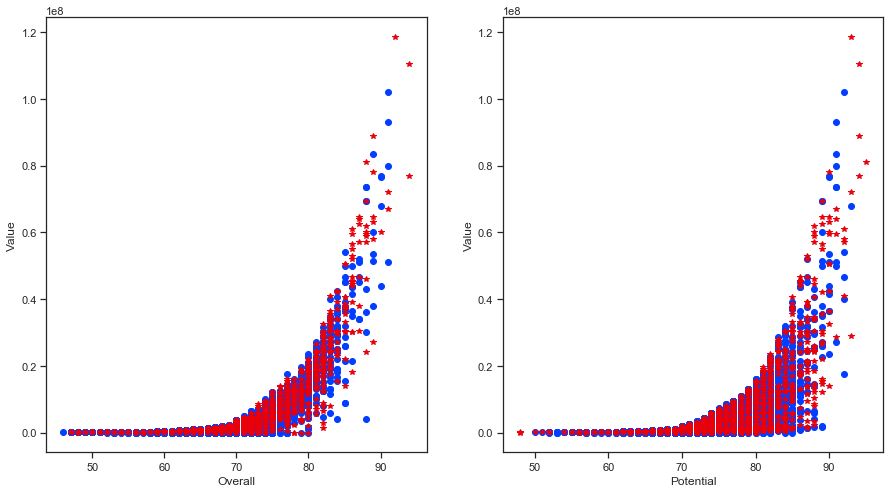

In [78]:
# Plot Inliner and Outlier - Overall against Value
fig, ax = plt.subplots(nrows = 1, ncols = 2 ,figsize = (15,8))
ax[0].plot(fifa_ad[fifa_ad['anomaly_svm']==1].Overall,fifa_ad[fifa_ad['anomaly_svm']==1].Value,'bo')
ax[0].plot(fifa_ad[fifa_ad['anomaly_svm']==-1].Overall,fifa_ad[fifa_ad['anomaly_svm']==-1].Value,'r*')
ax[0].set_xlabel('Overall')
ax[0].set_ylabel('Value')

ax[1].plot(fifa_ad[fifa_ad['anomaly_svm']==1].Potential,fifa_ad[fifa_ad['anomaly_svm']==1].Value,'bo')
ax[1].plot(fifa_ad[fifa_ad['anomaly_svm']==-1].Potential,fifa_ad[fifa_ad['anomaly_svm']==-1].Value,'r*')
ax[1].set_xlabel('Potential')
ax[1].set_ylabel('Value')

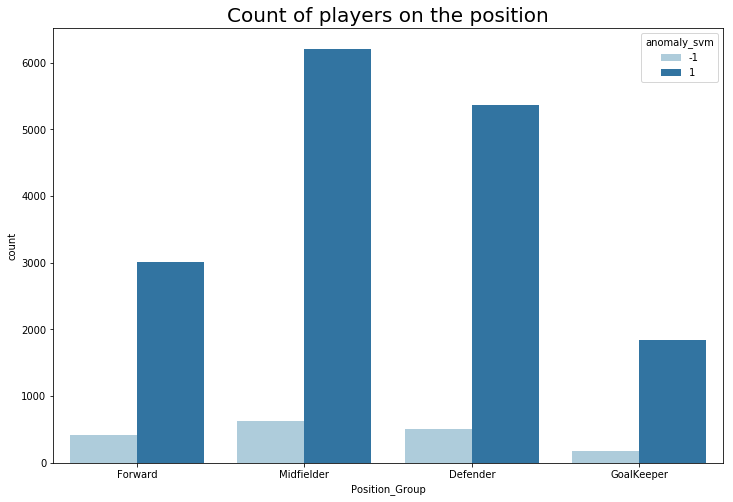

In [27]:
f, ax = plt.subplots(figsize=(12, 8))

ax = sns.countplot(x = 'Position_Group', data = fifa_ad,
                   order = ['Forward', 'Midfielder', 'Defender', 'GoalKeeper'], hue = 'anomaly_svm',palette="Paired")

ax.set_title(label='Count of players on the position', fontsize=20);

/Users/tammy/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning:

Using the stripplot function without specifying `order` is likely to produce an incorrect plot.



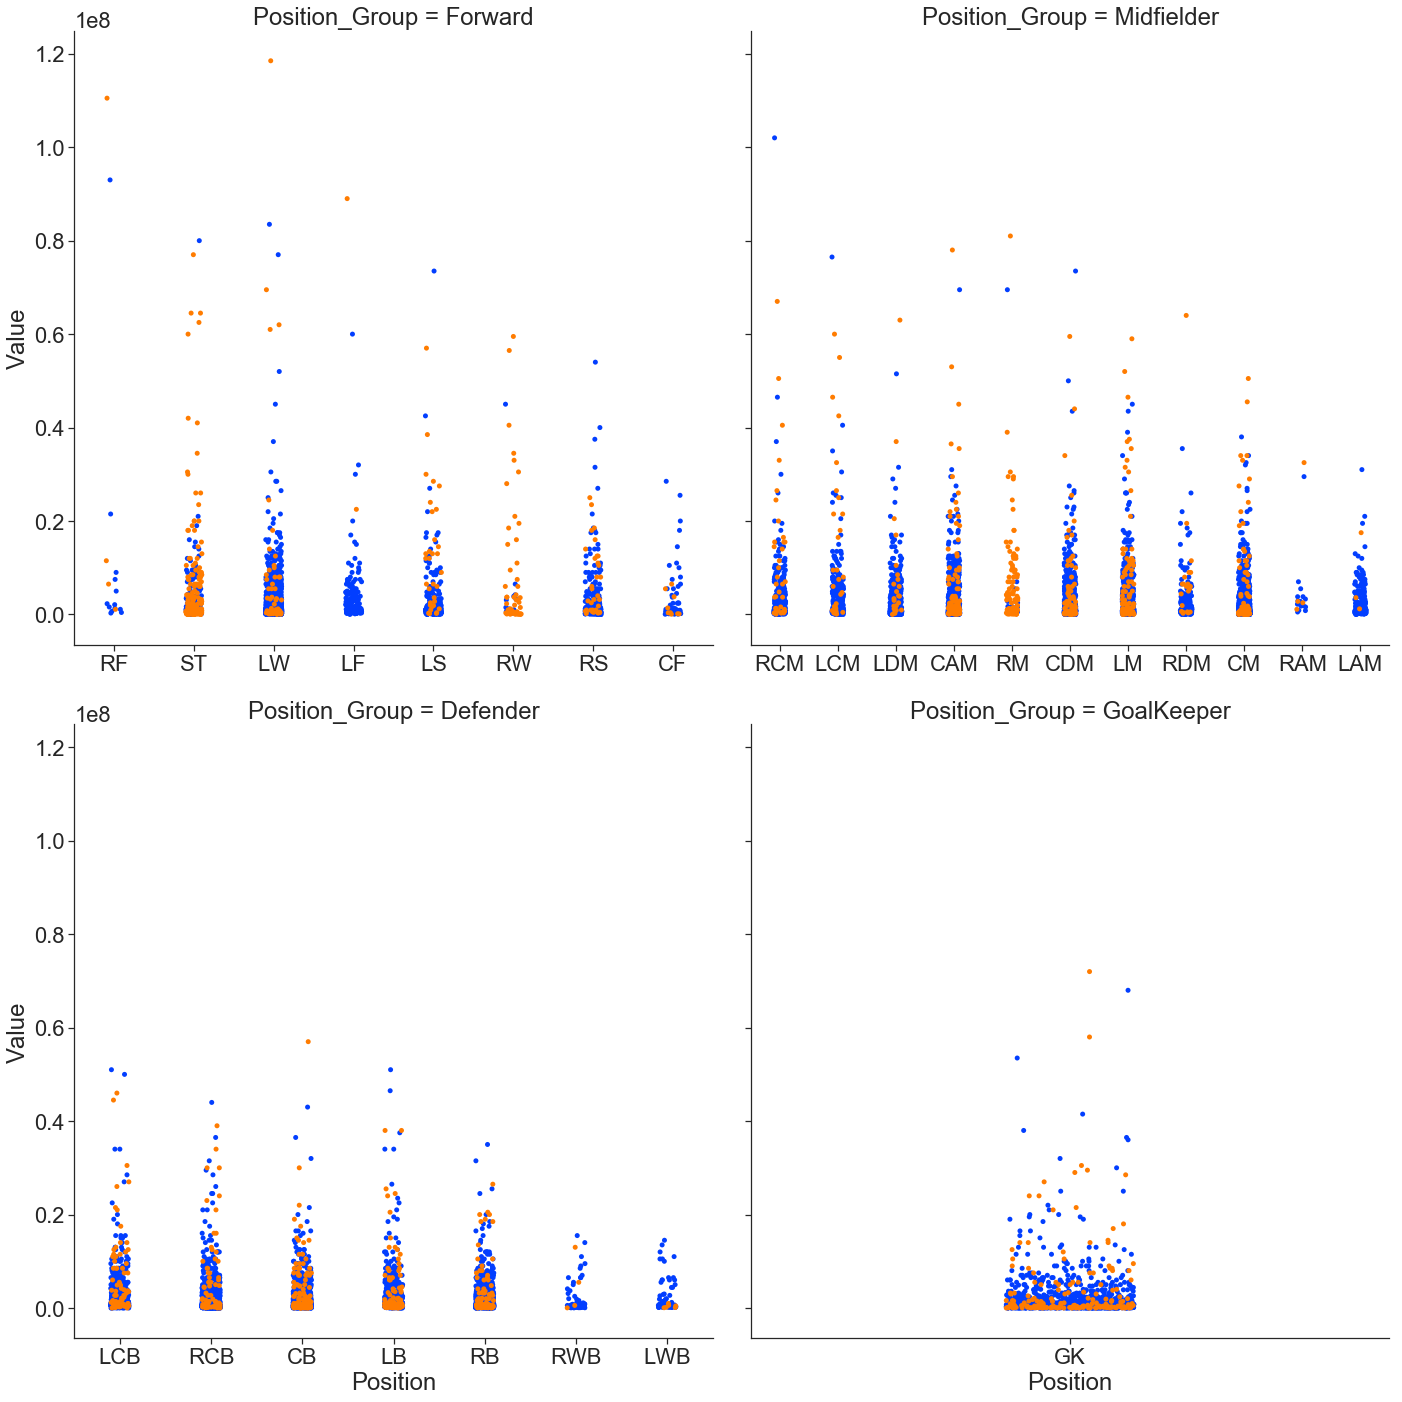

In [42]:
sns.set(font_scale=2, style ="ticks", palette = 'bright', color_codes=True)

g = sns.FacetGrid(fifa_ad, col="Position_Group", hue = 'anomaly_svm',
                  hue_order = [1,-1],
                  col_order = ['Forward', 'Midfielder', 'Defender', 'GoalKeeper']
                  ,sharex=False, sharey=True, col_wrap=2, height=10)

g.map(sns.stripplot, 'Position' ,"Value" )

sns.set(font_scale=1, style ="ticks", palette = 'bright', color_codes=True)

In [44]:
fifa_ad[fifa_ad['anomaly_svm']==1].sort_values(by=['Overall','Value'],ascending=False)

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,Club_Reputation,Attack_WR,Defense_WR,Position_Group,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Continent,anomaly_svm
4,4,K. De Bruyne,27,Belgium,91,92,Manchester City,102000000.0,355000.0,2281,1,4.0,5.0,4.0,Normal,1,RCM,7.0,1220,0,5,180,154,82,82,82,87,87,87,87,87,88,88,88,88,87,87,87,88,77,77,77,77,77,73,66,66,66,73,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,196400000.0,2.090909,High,High,Midfielder,3,80.8,87.2,80.2,82.0,80.833333,59.000000,11.2,1,Europe,1
5,5,E. Hazard,27,Belgium,91,91,Chelsea,93000000.0,340000.0,2142,1,4.0,4.0,4.0,Normal,1,LF,10.0,2375,0,2,173,163,83,83,83,89,88,88,88,89,89,89,89,89,82,82,82,89,66,63,63,63,66,60,49,49,49,60,81.0,84.0,61.0,89.0,80.0,95.0,83.0,79.0,83.0,94.0,94.0,88.0,95.0,90.0,94.0,82.0,56.0,83.0,66.0,80.0,54.0,41.0,87.0,89.0,86.0,91.0,34.0,27.0,22.0,11.0,12.0,6.0,8.0,8.0,172100000.0,2.121212,High,Medium,Forward,3,79.0,86.8,92.2,73.4,74.666667,27.666667,9.0,0,Europe,1
7,7,L. Suárez,31,Uruguay,91,91,FC Barcelona,80000000.0,455000.0,2346,1,5.0,4.0,3.0,Normal,1,RS,9.0,1635,0,3,183,190,87,87,87,86,87,87,87,86,85,85,85,84,79,79,79,84,69,68,68,68,69,66,63,63,63,66,77.0,93.0,77.0,82.0,88.0,87.0,86.0,84.0,64.0,90.0,86.0,75.0,82.0,92.0,83.0,86.0,69.0,90.0,83.0,85.0,87.0,41.0,92.0,84.0,85.0,85.0,62.0,45.0,38.0,27.0,25.0,31.0,33.0,37.0,164000000.0,2.242424,High,Medium,Forward,5,83.4,82.2,83.6,82.6,79.000000,48.333333,30.6,0,South America,1
8,8,Sergio Ramos,32,Spain,91,91,Real Madrid,51000000.0,380000.0,2201,1,4.0,3.0,3.0,Normal,1,RCB,15.0,4901,0,2,183,181,73,73,73,70,71,71,71,70,71,71,71,72,75,75,75,72,81,84,84,84,81,84,87,87,87,84,66.0,60.0,91.0,78.0,66.0,63.0,74.0,72.0,77.0,84.0,76.0,75.0,78.0,85.0,66.0,79.0,93.0,84.0,83.0,59.0,88.0,90.0,60.0,63.0,75.0,82.0,87.0,92.0,91.0,11.0,8.0,9.0,7.0,11.0,104600000.0,2.090909,High,Medium,Defender,3,72.2,74.0,76.0,79.6,76.333333,90.000000,9.2,0,Europe,1
10,10,R. Lewandowski,29,Poland,90,90,FC Bayern München,77000000.0,205000.0,2152,1,4.0,4.0,4.0,Normal,1,ST,9.0,1645,0,3,183,176,87,87,87,83,86,86,86,83,83,83,83,81,77,77,77,81,61,62,62,62,61,58,57,57,57,58,62.0,91.0,85.0,83.0,89.0,85.0,77.0,86.0,65.0,89.0,77.0,78.0,78.0,90.0,78.0,88.0,84.0,78.0,84.0,84.0,80.0,39.0,91.0,77.0,88.0,86.0,34.0,42.0,19.0,15.0,6.0,12.0,8.0,10.0,127100000.0,2.517241,High,Medium,Forward,3,82.0,80.4,80.2,83.6,76.833333,31.666667,10.2,0,Europe,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18143,18191,J. Norville-Williams,18,England,47,65,Cambridge United,50000.0,1000.0,1250,0,1.0,3.0,2.0,Lean,0,LB,24.0,184,0,3,180,168,39,39,39,43,40,40,40,43,41,41,41,43,40,40,40,43,45,44,44,44,45,45,47,47,47,45,47.0,26.0,39.0,39.0,27.0,45.0,29.0,21.0,41.0,41.0,61.0,52.0,55.0,45.0,59.0,26.0,61.0,38.0,55.0,25.0,55.0,55.0,47.0,39.0,29.0,36.0,45.0,42.0,46.0,15.0,13.0,6.0,14.0,12.0,119000.0,1.000000,Medium

In [43]:
fifa_ad[fifa_ad['anomaly_svm']==-1].sort_values(by=['Overall','Value'],ascending=False)

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,Club_Reputation,Attack_WR,Defense_WR,Position_Group,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Continent,anomaly_svm
0,0,L. Messi,31,Argentina,94,94,FC Barcelona,110500000.0,565000.0,2202,0,5.0,4.0,4.0,Lean,1,RF,10.0,5297,0,3,170,159,88,88,88,92,93,93,93,92,93,93,93,91,84,84,84,91,64,61,61,61,64,59,47,47,47,59,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,226500000.0,2.242424,Medium,Medium,Forward,2,85.0,93.4,91.6,75.6,71.500000,29.000000,10.8,0,South America,-1
1,1,Cristiano Ronaldo,33,Portugal,94,94,Juventus,77000000.0,405000.0,2228,1,5.0,4.0,5.0,Normal,1,ST,7.0,175,0,4,188,183,91,91,91,89,90,90,90,89,88,88,88,88,81,81,81,88,65,61,61,61,65,61,53,53,53,61,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,127100000.0,2.520000,High,Low,Forward,3,87.0,83.2,86.6,90.0,74.833333,27.333333,11.6,0,Europe,-1
2,2,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,118500000.0,290000.0,2143,1,5.0,5.0,5.0,Lean,1,LW,10.0,516,0,4,175,150,84,84,84,89,89,89,89,89,89,89,89,88,81,81,81,88,65,60,60,60,65,60,47,47,47,60,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,228100000.0,2.233333,High,Medium,Forward,3,79.2,88.8,91.6,70.6,73.833333,28.000000,11.8,1,South America,-1
3,3,De Gea,27,Spain,91,93,Manchester United,72000000.0,260000.0,1471,1,4.0,3.0,1.0,Lean,1,GK,1.0,2741,0,2,193,168,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,138600000.0,2.090909,Medium,Medium,GoalKeeper,0,22.8,30.2,61.6,43.4,42.666667,16.333333,88.8,2,Europe,-1
6,6,L. Modrić,32,Croatia,91,91,Real Madrid,67000000.0,420000.0,2280,1,4.0,4.0,4.0,Lean,1,RCM,10.0,2344,0,2,173,146,77,77,77,85,84,84,84,85,87,87,87,86,88,88,88,86,82,81,81,81,82,79,71,71,71,79,86.0,72.0,55.0,93.0,76.0,90.0,85.0,78.0,88.0,93.0,80.0,72.0,93.0,90.0,94.0,79.0,68.0,89.0,58.0,82.0,62.0,83.0,79.0,92.0,82.0,84.0,60.0,76.0,73.0,13.0,9.0,7.0,14.0,9.0,137400000.0,2.090909,High,High,Midfielder,3,76.4,86.8,85.8,75.2,80.333333,69.666667,10.4,0,Europe,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18141,18189,A. Kaltner,18,Germany,47,61,SpVgg Unterhaching,60000.0,1000.0,1290,1,1.0,3.0,2.0,Lean,0,ST,24.0,549,0,2,178,165,45,45,45,48,46,46,46,48,46,46,46,47,40,40,40,47,38,34,34,34,38,36,32,32,32,36,37.0,48.0,30.0,45.0,43.0,50.0,41.0,38.0,30.0,51.0,62.0,66.0,67.0,39.0,70.0,38.0,81.0,55.0,60.0,35.0,28.0,25.0,43.0,41.0,48.0,37.0,28.0,15.0,22.0,15.0,5.0,14.0,12.0,8.0,125000.0,1.000000,Medium,Medium,Forward,2,40.6,42.0

---

### What will happen if we run the model separately on the GoalKeeper group?

In [31]:
fifa_gk

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,Club_Reputation,Attack_WR,Defense_WR,Position_Group,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Continent
3,3,De Gea,27,Spain,91,93,Manchester United,72000000.0,260000.0,1471,1,4.0,3.0,1.0,Lean,1,GK,1.0,2741,0,2,193,168,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,138600000.0,2.090909,Medium,Medium,GoalKeeper,0,22.8,30.2,61.6,43.4,42.666667,16.333333,88.8,2,Europe
9,9,J. Oblak,25,Slovenia,90,93,Atlético Madrid,68000000.0,94000.0,1331,1,3.0,3.0,1.0,Normal,1,GK,1.0,1630,0,3,188,192,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13.0,11.0,15.0,29.0,13.0,12.0,13.0,14.0,26.0,16.0,43.0,60.0,67.0,86.0,49.0,22.0,76.0,41.0,78.0,12.0,34.0,19.0,11.0,70.0,11.0,70.0,27.0,12.0,18.0,86.0,92.0,78.0,88.0,89.0,144500000.0,1.878788,Medium,Medium,GoalKeeper,0,16.2,16.2,61.0,45.8,35.833333,19.000000,86.6,3,Europe
18,18,M. ter Stegen,26,Germany,89,92,FC Barcelona,58000000.0,240000.0,1328,1,3.0,4.0,1.0,Normal,1,GK,22.0,1645,0,4,188,187,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15.0,14.0,11.0,36.0,14.0,17.0,18.0,12.0,42.0,18.0,38.0,50.0,37.0,85.0,43.0,22.0,79.0,35.0,79.0,10.0,43.0,22.0,11.0,69.0,25.0,69.0,25.0,13.0,10.0,87.0,85.0,88.0,85.0,90.0,123300000.0,2.242424,Medium,Medium,GoalKeeper,0,18.0,21.4,50.6,45.0,39.833333,16.000000,87.0,3,Europe
19,19,T. Courtois,26,Belgium,89,90,Real Madrid,53500000.0,240000.0,1311,0,4.0,2.0,1.0,Normal,1,GK,1.0,145,0,6,198,212,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14.0,14.0,13.0,33.0,12.0,13.0,19.0,20.0,35.0,23.0,46.0,52.0,61.0,84.0,45.0,36.0,68.0,38.0,70.0,17.0,23.0,15.0,13.0,44.0,27.0,66.0,20.0,18.0,16.0,85.0,91.0,72.0,86.0,88.0,113700000.0,2.090909,Medium,Medium,GoalKeeper,0,17.2,22.0,57.6,45.8,31.333333,18.000000,84.4,1,Europe
22,22,M. Neuer,32,Germany,89,89,FC Bayern München,38000000.0,130000.0,1473,1,5.0,4.0,1.0,Normal,1,GK,1.0,2741,0,3,193,203,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15.0,13.0,25.0,55.0,11.0,30.0,14.0,11.0,59.0,48.0,54.0,60.0,51.0,84.0,35.0,25.0,77.0,43.0,80.0,16.0,29.0,30.0,12.0,70.0,47.0,70.0,17.0,10.0,11.0,90.0,86.0,91.0,87.0,87.0,62700000.0,2.517241,Medium,Medium,GoalKeeper,0,23.8,32.4,56.8,48.2,43.000000,12.666667,88.2,0,Europe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18130,18178,L. Wahlstedt,18,Sweden,48,65,Dalkurd FF,50000.0,1000.0,738,1,1.0,2.0,1.0,Lean,0,GK,30.0,272,0,0,183,176,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0,7.0,11.0,22.0,6.0,8.0,10.0,8.0,20.0,12.0,24.0,28.0,33.0,40.0,29.0,15.0,48.0,20.0,38.0,6.0,20.0,10.0,7.0,18.0,12.0,28.0,16.0,11.0,10.0,47.0,46.0,50.0,45.0,51.0,94000.0,1.000000,Medium,Medium,GoalKeeper,0,11.2,11.6,30.8,25.4,15.833333,12.333333,47.8,17,Europe
18132,18180,M. Hurst,22,Scotland,48,58,St. Johnstone FC,40000.0,1000.0,987,1,1.0,2.0,1.0,Lean,0,GK,30.0,

In [32]:
clf = svm.OneClassSVM(nu=0.02, kernel="rbf", gamma=0.1)

clf.fit(anomaly_gk_scaled)
pred_gk = clf.predict(anomaly_gk_scaled)
fifa_gk['anomaly_svm']=pred_gk
outliers=fifa_gk.loc[fifa_gk['anomaly_svm']==-1]
outlier_index=list(outliers.index)

#Find the number of anomalies and normal points here points classified -1 are anomalous
print(fifa_gk['anomaly_svm'].value_counts())

-1    1033
 1     993
Name: anomaly_svm, dtype: int64


/Users/tammy/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning:

Using the stripplot function without specifying `order` is likely to produce an incorrect plot.



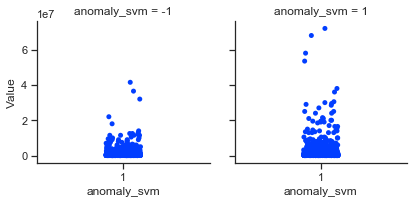

In [34]:
sns.set(font_scale=1, style ="ticks", palette = 'bright', color_codes=True)
g = sns.FacetGrid(fifa_gk, col="anomaly_svm")

g.map(sns.stripplot, 'anomaly_svm' ,"Value" )

Text(0, 0.5, 'Value')

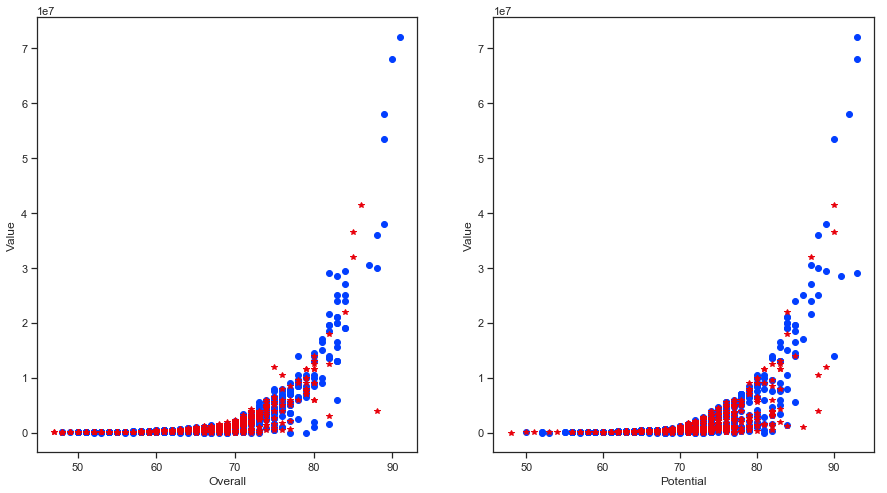

In [80]:
fig, ax = plt.subplots(nrows = 1, ncols = 2 ,figsize = (15,8))

ax[0].plot(fifa_gk[fifa_gk['anomaly_svm']==1].Overall,fifa_gk[fifa_gk['anomaly_svm']==1].Value,'bo')
ax[0].plot(fifa_gk[fifa_gk['anomaly_svm']==-1].Overall,fifa_gk[fifa_gk['anomaly_svm']==-1].Value,'r*')
ax[0].set_xlabel('Overall')
ax[0].set_ylabel('Value')


ax[1].plot(fifa_gk[fifa_gk['anomaly_svm']==1].Potential,fifa_gk[fifa_gk['anomaly_svm']==1].Value,'bo')
ax[1].plot(fifa_gk[fifa_gk['anomaly_svm']==-1].Potential,fifa_gk[fifa_gk['anomaly_svm']==-1].Value,'r*')
ax[1].set_xlabel('Potential')
ax[1].set_ylabel('Value')

Text(0, 0.5, 'Value')

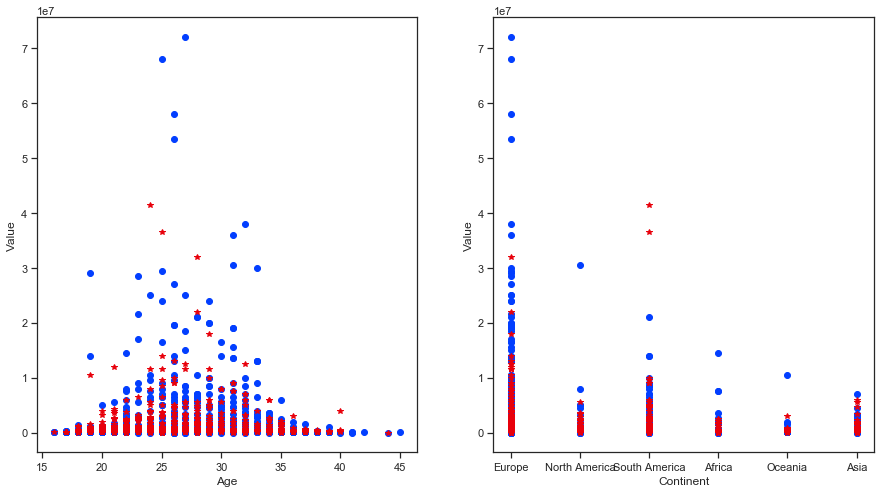

In [84]:
# Plot Inliner and Outlier - Overall against Value
fig, ax = plt.subplots(nrows = 1, ncols = 2 ,figsize = (15,8))

ax[0].plot(fifa_gk[fifa_gk['anomaly_svm']==1].Age,fifa_gk[fifa_gk['anomaly_svm']==1].Value,'bo')
ax[0].plot(fifa_gk[fifa_gk['anomaly_svm']==-1].Age,fifa_gk[fifa_gk['anomaly_svm']==-1].Value,'r*')
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Value')


ax[1].plot(fifa_gk[fifa_gk['anomaly_svm']==1].Continent,fifa_gk[fifa_gk['anomaly_svm']==1].Value,'bo')
ax[1].plot(fifa_gk[fifa_gk['anomaly_svm']==-1].Continent,fifa_gk[fifa_gk['anomaly_svm']==-1].Value,'r*')
ax[1].set_xlabel('Continent')
ax[1].set_ylabel('Value')



In [57]:
fifa_gk

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,Club_Reputation,Attack_WR,Defense_WR,Position_Group,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Continent,anomaly_svm
3,3,De Gea,27,Spain,91,93,Manchester United,72000000.0,260000.0,1471,1,4.0,3.0,1.0,Lean,1,GK,1.0,2741,0,2,193,168,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,138600000.0,2.090909,Medium,Medium,GoalKeeper,0,22.8,30.2,61.6,43.4,42.666667,16.333333,88.8,2,Europe,1
9,9,J. Oblak,25,Slovenia,90,93,Atlético Madrid,68000000.0,94000.0,1331,1,3.0,3.0,1.0,Normal,1,GK,1.0,1630,0,3,188,192,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13.0,11.0,15.0,29.0,13.0,12.0,13.0,14.0,26.0,16.0,43.0,60.0,67.0,86.0,49.0,22.0,76.0,41.0,78.0,12.0,34.0,19.0,11.0,70.0,11.0,70.0,27.0,12.0,18.0,86.0,92.0,78.0,88.0,89.0,144500000.0,1.878788,Medium,Medium,GoalKeeper,0,16.2,16.2,61.0,45.8,35.833333,19.000000,86.6,3,Europe,1
18,18,M. ter Stegen,26,Germany,89,92,FC Barcelona,58000000.0,240000.0,1328,1,3.0,4.0,1.0,Normal,1,GK,22.0,1645,0,4,188,187,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15.0,14.0,11.0,36.0,14.0,17.0,18.0,12.0,42.0,18.0,38.0,50.0,37.0,85.0,43.0,22.0,79.0,35.0,79.0,10.0,43.0,22.0,11.0,69.0,25.0,69.0,25.0,13.0,10.0,87.0,85.0,88.0,85.0,90.0,123300000.0,2.242424,Medium,Medium,GoalKeeper,0,18.0,21.4,50.6,45.0,39.833333,16.000000,87.0,3,Europe,1
19,19,T. Courtois,26,Belgium,89,90,Real Madrid,53500000.0,240000.0,1311,0,4.0,2.0,1.0,Normal,1,GK,1.0,145,0,6,198,212,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14.0,14.0,13.0,33.0,12.0,13.0,19.0,20.0,35.0,23.0,46.0,52.0,61.0,84.0,45.0,36.0,68.0,38.0,70.0,17.0,23.0,15.0,13.0,44.0,27.0,66.0,20.0,18.0,16.0,85.0,91.0,72.0,86.0,88.0,113700000.0,2.090909,Medium,Medium,GoalKeeper,0,17.2,22.0,57.6,45.8,31.333333,18.000000,84.4,1,Europe,1
22,22,M. Neuer,32,Germany,89,89,FC Bayern München,38000000.0,130000.0,1473,1,5.0,4.0,1.0,Normal,1,GK,1.0,2741,0,3,193,203,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15.0,13.0,25.0,55.0,11.0,30.0,14.0,11.0,59.0,48.0,54.0,60.0,51.0,84.0,35.0,25.0,77.0,43.0,80.0,16.0,29.0,30.0,12.0,70.0,47.0,70.0,17.0,10.0,11.0,90.0,86.0,91.0,87.0,87.0,62700000.0,2.517241,Medium,Medium,GoalKeeper,0,23.8,32.4,56.8,48.2,43.000000,12.666667,88.2,0,Europe,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18130,18178,L. Wahlstedt,18,Sweden,48,65,Dalkurd FF,50000.0,1000.0,738,1,1.0,2.0,1.0,Lean,0,GK,30.0,272,0,0,183,176,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0,7.0,11.0,22.0,6.0,8.0,10.0,8.0,20.0,12.0,24.0,28.0,33.0,40.0,29.0,15.0,48.0,20.0,38.0,6.0,20.0,10.0,7.0,18.0,12.0,28.0,16.0,11.0,10.0,47.0,46.0,50.0,45.0,51.0,94000.0,1.000000,Medium,Medium,GoalKeeper,0,11.2,11.6,30.8,25.4,15.833333,12.333333,47.8,17,Europe,1
18132,18180,M. Hurst,22,Scotland,48,58,St. Johnstone FC,40000.0,1000.0,987,1

In [122]:
fifa_gk[fifa_gk['anomaly_svm']==1].sort_values(by=['Overall','Value'],ascending=False)

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,Club_Reputation,Attack_WR,Defense_WR,Position_Group,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Continent,anomaly_svm
3,3,De Gea,27,Spain,91,93,Manchester United,72000000.0,260000.0,1471,1,4.0,3.0,1.0,Lean,1,GK,1.0,2741,0,2,193,168,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,138600000.0,2.090909,Medium,Medium,GoalKeeper,0,22.8,30.2,61.6,43.4,42.666667,16.333333,88.8,2,Europe,1
9,9,J. Oblak,25,Slovenia,90,93,Atlético Madrid,68000000.0,94000.0,1331,1,3.0,3.0,1.0,Normal,1,GK,1.0,1630,0,3,188,192,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13.0,11.0,15.0,29.0,13.0,12.0,13.0,14.0,26.0,16.0,43.0,60.0,67.0,86.0,49.0,22.0,76.0,41.0,78.0,12.0,34.0,19.0,11.0,70.0,11.0,70.0,27.0,12.0,18.0,86.0,92.0,78.0,88.0,89.0,144500000.0,1.878788,Medium,Medium,GoalKeeper,0,16.2,16.2,61.0,45.8,35.833333,19.000000,86.6,3,Europe,1
18,18,M. ter Stegen,26,Germany,89,92,FC Barcelona,58000000.0,240000.0,1328,1,3.0,4.0,1.0,Normal,1,GK,22.0,1645,0,4,188,187,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15.0,14.0,11.0,36.0,14.0,17.0,18.0,12.0,42.0,18.0,38.0,50.0,37.0,85.0,43.0,22.0,79.0,35.0,79.0,10.0,43.0,22.0,11.0,69.0,25.0,69.0,25.0,13.0,10.0,87.0,85.0,88.0,85.0,90.0,123300000.0,2.242424,Medium,Medium,GoalKeeper,0,18.0,21.4,50.6,45.0,39.833333,16.000000,87.0,3,Europe,1
19,19,T. Courtois,26,Belgium,89,90,Real Madrid,53500000.0,240000.0,1311,0,4.0,2.0,1.0,Normal,1,GK,1.0,145,0,6,198,212,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14.0,14.0,13.0,33.0,12.0,13.0,19.0,20.0,35.0,23.0,46.0,52.0,61.0,84.0,45.0,36.0,68.0,38.0,70.0,17.0,23.0,15.0,13.0,44.0,27.0,66.0,20.0,18.0,16.0,85.0,91.0,72.0,86.0,88.0,113700000.0,2.090909,Medium,Medium,GoalKeeper,0,17.2,22.0,57.6,45.8,31.333333,18.000000,84.4,1,Europe,1
22,22,M. Neuer,32,Germany,89,89,FC Bayern München,38000000.0,130000.0,1473,1,5.0,4.0,1.0,Normal,1,GK,1.0,2741,0,3,193,203,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15.0,13.0,25.0,55.0,11.0,30.0,14.0,11.0,59.0,48.0,54.0,60.0,51.0,84.0,35.0,25.0,77.0,43.0,80.0,16.0,29.0,30.0,12.0,70.0,47.0,70.0,17.0,10.0,11.0,90.0,86.0,91.0,87.0,87.0,62700000.0,2.517241,Medium,Medium,GoalKeeper,0,23.8,32.4,56.8,48.2,43.000000,12.666667,88.2,0,Europe,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17977,18025,J. Miszczuk,27,Poland,50,50,Jagiellonia Białystok,20000.0,1000.0,941,1,1.0,2.0,1.0,Normal,0,GK,66.0,146,0,1,185,168,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.0,11.0,14.0,40.0,14.0,19.0,12.0,24.0,34.0,18.0,25.0,28.0,32.0,53.0,37.0,13.0,51.0,28.0,52.0,8.0,37.0,22.0,11.0,30.0,22.0,22.0,15.0,19.0,17.0,48.0,48.0,49.0,48.0,51.0,27000.0,1.000000,Medium,Medium,GoalKeeper,0,18.0,21.4,35.0,30.4,24.000000,17.000000,48.8,0,Europe,1
18026,18074,Sun Qibin,26,China PR,50,52,Tianjin Quanjian FC,

In [121]:
fifa_gk[fifa_gk['anomaly_svm']==-1].sort_values(by=['Value','Overall'],ascending=False)

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,Club_Reputation,Attack_WR,Defense_WR,Position_Group,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Continent,anomaly_svm
57,57,Ederson,24,Brazil,86,90,Manchester City,41500000.0,125000.0,1463,0,2.0,3.0,1.0,Normal,1,GK,31.0,549,0,7,188,190,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20.0,14.0,14.0,56.0,18.0,23.0,15.0,20.0,58.0,37.0,64.0,63.0,60.0,86.0,48.0,42.0,58.0,41.0,68.0,18.0,35.0,25.0,20.0,67.0,17.0,70.0,28.0,15.0,8.0,85.0,80.0,91.0,82.0,87.0,79900000.0,2.090909,Medium,Medium,GoalKeeper,0,24.4,30.6,64.2,45.4,39.000000,17.000000,85.0,4,South America,-1
81,81,Alisson,25,Brazil,85,90,Liverpool,36500000.0,115000.0,1320,1,3.0,3.0,1.0,Normal,1,GK,13.0,166,0,6,190,201,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17.0,13.0,19.0,45.0,20.0,27.0,19.0,18.0,44.0,30.0,54.0,45.0,40.0,84.0,37.0,21.0,52.0,32.0,78.0,14.0,27.0,11.0,13.0,66.0,23.0,65.0,15.0,19.0,16.0,83.0,81.0,85.0,84.0,88.0,72100000.0,1.969697,Medium,Medium,GoalKeeper,0,22.8,27.6,52.0,39.4,34.166667,16.666667,84.2,5,South America,-1
92,92,W. Szczęsny,28,Poland,85,87,Juventus,32000000.0,125000.0,1270,1,3.0,3.0,1.0,Lean,1,GK,1.0,531,0,3,196,198,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12.0,12.0,16.0,32.0,14.0,11.0,16.0,14.0,36.0,22.0,51.0,47.0,55.0,82.0,51.0,15.0,71.0,45.0,65.0,14.0,40.0,15.0,14.0,48.0,18.0,65.0,20.0,13.0,12.0,85.0,81.0,71.0,85.0,87.0,55200000.0,2.520000,Medium,Medium,GoalKeeper,0,17.2,19.8,57.2,42.0,33.333333,15.000000,81.8,2,Europe,-1
133,133,L. Hrádecký,28,Finland,84,84,Bayer 04 Leverkusen,22000000.0,74000.0,1132,1,2.0,3.0,1.0,Lean,0,GK,1.0,184,0,5,193,187,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.0,11.0,11.0,15.0,9.0,10.0,11.0,15.0,20.0,20.0,38.0,44.0,43.0,83.0,39.0,14.0,69.0,34.0,55.0,14.0,31.0,18.0,9.0,53.0,20.0,48.0,10.0,10.0,13.0,85.0,79.0,68.0,82.0,88.0,37400000.0,1.653846,Medium,Medium,GoalKeeper,0,11.4,15.2,49.4,37.2,29.833333,11.000000,80.4,0,Europe,-1
266,266,J. Cillessen,29,Netherlands,82,84,FC Barcelona,18000000.0,135000.0,1292,1,3.0,3.0,1.0,Normal,0,GK,1.0,859,0,3,185,183,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17.0,10.0,12.0,47.0,19.0,12.0,10.0,10.0,33.0,32.0,54.0,50.0,48.0,78.0,50.0,35.0,71.0,40.0,67.0,15.0,25.0,25.0,11.0,60.0,21.0,61.0,18.0,12.0,11.0,80.0,83.0,75.0,81.0,80.0,38300000.0,2.242424,Medium,Medium,GoalKeeper,0,21.0,19.4,56.0,45.6,33.833333,13.666667,79.8,2,Europe,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15345,15393,A. Busti,18,Canada,59,77,No_Club,0.0,1594.0,956,1,1.0,2.0,1.0,Normal,0,GK,23.0,0,0,0,183,165,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12.0,9.0,18.0,27.0,7.0,12.0,10.0,13.0,27.0,14.0,34.0,32.0,29.0,55.0,48.0,22.0,63.0,27.0,53.0,8.0,34.0,14.0,9.0,41.0,12.0,39.0,9.0,14.0,13.0,59.0,59.0,56.0,57.0,59.0,0.0,1.062241,Medium,Medium,GoalKeeper,0,14.6,15.2,39.6,34.6,24.833333,12.000000,58.0,18,North America,-1
15714,15762,M. Crocombe,24,New Zealand,59,63,No_Club,0.0,1594.0,1134,1,1

---

## 2.`MODEL 2: ISOLATION FOREST`

The term isolation means ‘separating an instance from the rest of the instances’. Since anomalies are ‘few and different’ and therefore they are more susceptible to isolation. In a data-induced random tree, partitioning of instances are repeated recursively until all instances are isolated. This random partitioning produces noticeable  shorter paths for anomalies since the fewer instances of anomalies result in a smaller number of partitions – shorter paths in a tree structure, and instances with distinguishable attribute-values are more likely to be separated in early partitioning. Hence, when a forest of random trees collectively produce **shorter path lengths** for some particular points, then they are **highly likely to be anomalies**. 

The forest part comes in when a bunch of these decision trees are created and the scores are averaged, which gives a good idea about which observations are truly anomalies. As a result, Isolation Forests are used for outlier and anomaly detection.

**SUMMARY  HOW IT WORKS:**

Few and different to be isolated quicker

● For each tree:

    ○ Get a sample of the data
    ○ Randomly select a dimension
    ○ Randomly pick a value in that dimension
    ○ Draw a straight line through the data at that
      value and split data
    ○ Repeat until tree is complete
    
● Generate multiple trees → forest

● Anomalies will be isolated in only a few steps

● Nominal points in more

In [123]:
fifa_ad

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,Club_Reputation,Attack_WR,Defense_WR,Position_Group,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Continent,anomaly_svm
0,0,L. Messi,31,Argentina,94,94,FC Barcelona,110500000.0,565000.0,2202,0,5.0,4.0,4.0,Lean,1,RF,10.0,5297,0,3,170,159,88,88,88,92,93,93,93,92,93,93,93,91,84,84,84,91,64,61,61,61,64,59,47,47,47,59,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,226500000.0,2.242424,Medium,Medium,Forward,2,85.0,93.4,91.6,75.6,71.500000,29.000000,10.8,0,South America,-1
1,1,Cristiano Ronaldo,33,Portugal,94,94,Juventus,77000000.0,405000.0,2228,1,5.0,4.0,5.0,Normal,1,ST,7.0,175,0,4,188,183,91,91,91,89,90,90,90,89,88,88,88,88,81,81,81,88,65,61,61,61,65,61,53,53,53,61,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,127100000.0,2.520000,High,Low,Forward,3,87.0,83.2,86.6,90.0,74.833333,27.333333,11.6,0,Europe,-1
2,2,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,118500000.0,290000.0,2143,1,5.0,5.0,5.0,Lean,1,LW,10.0,516,0,4,175,150,84,84,84,89,89,89,89,89,89,89,89,88,81,81,81,88,65,60,60,60,65,60,47,47,47,60,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,228100000.0,2.233333,High,Medium,Forward,3,79.2,88.8,91.6,70.6,73.833333,28.000000,11.8,1,South America,-1
3,3,De Gea,27,Spain,91,93,Manchester United,72000000.0,260000.0,1471,1,4.0,3.0,1.0,Lean,1,GK,1.0,2741,0,2,193,168,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,138600000.0,2.090909,Medium,Medium,GoalKeeper,0,22.8,30.2,61.6,43.4,42.666667,16.333333,88.8,2,Europe,-1
4,4,K. De Bruyne,27,Belgium,91,92,Manchester City,102000000.0,355000.0,2281,1,4.0,5.0,4.0,Normal,1,RCM,7.0,1220,0,5,180,154,82,82,82,87,87,87,87,87,88,88,88,88,87,87,87,88,77,77,77,77,77,73,66,66,66,73,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,196400000.0,2.090909,High,High,Midfielder,3,80.8,87.2,80.2,82.0,80.833333,59.000000,11.2,1,Europe,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18154,18202,J. Lundstram,19,England,47,65,Crewe Alexandra,60000.0,1000.0,1307,1,1.0,2.0,2.0,Lean,0,CM,22.0,608,0,1,175,134,42,42,42,44,44,44,44,44,45,45,45,44,45,45,45,44,44,45,45,45,44,45,45,45,45,45,34.0,38.0,40.0,49.0,25.0,42.0,30.0,34.0,45.0,43.0,54.0,57.0,60.0,49.0,76.0,43.0,55.0,40.0,47.0,38.0,46.0,46.0,39.0,52.0,43.0,45.0,40.0,48.0,47.0,10.0,13.0,7.0,8.0,9.0,143000.0,1.035714,Medium,Medium,Midfielder,

In [124]:
from sklearn.ensemble import IsolationForest

In [125]:
clf=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12), \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=119, verbose=0)
clf.fit(anomaly_scaled)
pred = clf.predict(anomaly_scaled)
fifa_ad['anomaly_if']=pred
outliers=fifa_ad.loc[fifa_ad['anomaly_if']==-1]
outlier_index=list(outliers.index)
#print(outlier_index)
#Find the number of anomalies and normal points here points classified -1 are anomalous
print(fifa_ad['anomaly_if'].value_counts())

/Users/tammy/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.

/Users/tammy/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.



 1    15980
-1     2179
Name: anomaly_if, dtype: int64


In [126]:
fifa_ad[fifa_ad['anomaly_if'] == -1]

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,Club_Reputation,Attack_WR,Defense_WR,Position_Group,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Continent,anomaly_svm,anomaly_if
0,0,L. Messi,31,Argentina,94,94,FC Barcelona,110500000.0,565000.0,2202,0,5.0,4.0,4.0,Lean,1,RF,10.0,5297,0,3,170,159,88,88,88,92,93,93,93,92,93,93,93,91,84,84,84,91,64,61,61,61,64,59,47,47,47,59,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,226500000.0,2.242424,Medium,Medium,Forward,2,85.0,93.4,91.6,75.6,71.500000,29.000000,10.8,0,South America,-1,-1
1,1,Cristiano Ronaldo,33,Portugal,94,94,Juventus,77000000.0,405000.0,2228,1,5.0,4.0,5.0,Normal,1,ST,7.0,175,0,4,188,183,91,91,91,89,90,90,90,89,88,88,88,88,81,81,81,88,65,61,61,61,65,61,53,53,53,61,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,127100000.0,2.520000,High,Low,Forward,3,87.0,83.2,86.6,90.0,74.833333,27.333333,11.6,0,Europe,-1,-1
2,2,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,118500000.0,290000.0,2143,1,5.0,5.0,5.0,Lean,1,LW,10.0,516,0,4,175,150,84,84,84,89,89,89,89,89,89,89,89,88,81,81,81,88,65,60,60,60,65,60,47,47,47,60,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,228100000.0,2.233333,High,Medium,Forward,3,79.2,88.8,91.6,70.6,73.833333,28.000000,11.8,1,South America,-1,-1
3,3,De Gea,27,Spain,91,93,Manchester United,72000000.0,260000.0,1471,1,4.0,3.0,1.0,Lean,1,GK,1.0,2741,0,2,193,168,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,138600000.0,2.090909,Medium,Medium,GoalKeeper,0,22.8,30.2,61.6,43.4,42.666667,16.333333,88.8,2,Europe,-1,-1
4,4,K. De Bruyne,27,Belgium,91,92,Manchester City,102000000.0,355000.0,2281,1,4.0,5.0,4.0,Normal,1,RCM,7.0,1220,0,5,180,154,82,82,82,87,87,87,87,87,88,88,88,88,87,87,87,88,77,77,77,77,77,73,66,66,66,73,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,196400000.0,2.090909,High,High,Midfielder,3,80.8,87.2,80.2,82.0,80.833333,59.000000,11.2,1,Europe,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18146,18194,J. Milli,18,Italy,47,65,Lecce,50000.0,1000.0,731,1,1.0,3.0,1.0,Normal,0,GK,32.0,184,0,3,190,187,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0,6.0,10.0,25.0,6.0,12.0,13.0,10.0,20.0,17.0,20.0,14.0,39.0,37.0,22.0,22.0,33.0,15.0,59.0,5.0,17.0,5.0,3.0,28.0,16.0,23.0,6.0,10.0,11.0,52.0,52.0,52.0,40.0,44.0,109000.0,1.034483,Medium,Medium,GoalKeeper,0,11.4,14.4,26

In [127]:
fifa_ad[fifa_ad['anomaly_if'] == 1]

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,Club_Reputation,Attack_WR,Defense_WR,Position_Group,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Continent,anomaly_svm,anomaly_if
48,48,C. Immobile,28,Italy,87,87,Lazio,52000000.0,115000.0,2009,1,3.0,4.0,3.0,Normal,1,ST,17.0,888,0,5,185,187,84,84,84,79,82,82,82,79,78,78,78,77,70,70,70,77,60,58,58,58,60,58,55,55,55,58,55.0,90.0,81.0,74.0,87.0,83.0,70.0,51.0,49.0,83.0,78.0,85.0,77.0,87.0,63.0,86.0,77.0,80.0,76.0,80.0,77.0,40.0,91.0,65.0,78.0,81.0,34.0,33.0,32.0,6.0,8.0,15.0,12.0,6.0,88400000.0,1.593750,High,Medium,Forward,3,77.4,67.2,78.0,79.8,72.000000,33.000000,9.4,0,Europe,1,1
89,89,N. Otamendi,30,Argentina,85,85,Manchester City,28500000.0,170000.0,1916,1,3.0,3.0,2.0,Normal,1,CB,30.0,1230,0,4,183,179,64,64,64,59,61,61,61,59,62,62,62,61,67,67,67,61,72,77,77,77,72,74,82,82,82,74,52.0,54.0,85.0,75.0,57.0,51.0,50.0,39.0,72.0,70.0,57.0,61.0,64.0,79.0,62.0,69.0,92.0,67.0,80.0,56.0,91.0,84.0,51.0,53.0,45.0,80.0,83.0,85.0,84.0,12.0,5.0,8.0,11.0,12.0,52700000.0,2.090909,High,High,Defender,3,64.6,56.4,64.6,72.8,67.333333,84.000000,9.6,0,South America,1,1
90,90,Parejo,29,Spain,85,85,Valencia CF,37000000.0,66000.0,2119,1,2.0,4.0,3.0,Lean,1,RCM,10.0,2741,0,2,183,163,74,74,74,77,77,77,77,77,80,80,80,78,83,83,83,78,74,77,77,77,74,71,69,69,69,71,84.0,79.0,61.0,90.0,72.0,78.0,89.0,90.0,87.0,84.0,51.0,43.0,66.0,78.0,72.0,78.0,51.0,78.0,72.0,82.0,58.0,81.0,81.0,86.0,83.0,78.0,69.0,68.0,60.0,5.0,9.0,12.0,14.0,8.0,77700000.0,1.454545,Medium,Low,Midfielder,2,77.2,85.6,62.0,72.2,77.833333,65.666667,9.6,0,Europe,1,1
100,100,Diego Costa,29,Spain,85,85,Atlético Madrid,38500000.0,100000.0,2003,1,4.0,4.0,2.0,Normal,1,LS,19.0,365,0,3,188,190,82,82,82,76,79,79,79,76,75,75,75,75,69,69,69,75,61,61,61,61,61,59,61,61,61,59,65.0,87.0,82.0,65.0,81.0,77.0,62.0,59.0,52.0,83.0,74.0,76.0,58.0,85.0,53.0,83.0,64.0,76.0,92.0,74.0,93.0,40.0,87.0,74.0,75.0,83.0,58.0,39.0,34.0,11.0,13.0,12.0,8.0,11.0,78900000.0,1.878788,High,Medium,Forward,3,76.0,66.6,69.2,77.8,75.333333,43.666667,11.0,0,Europe,-1,1
107,107,V. Kompany,32,Belgium,85,85,Manchester City,22000000.0,170000.0,1898,1,4.0,3.0,2.0,Normal,1,CB,4.0,3784,0,1,190,187,63,63,63,60,61,61,61,60,62,62,62,62,67,67,67,62,73,77,77,77,73,75,83,83,83,75,61.0,45.0,84.0,73.0,46.0,63.0,61.0,52.0,66.0,70.0,52.0,59.0,57.0,87.0,41.0,75.0,72.0,66.0,87.0,55.0,87.0,82.0,41.0,59.0,63.0,81.0,87.0,85.0,84.0,10.0,9.0,5.0,8.0,6.0,40700000.0,2.090909,Medium,High,Defender,3,61.8,62.4,59.2,71.0,68.833333,85.333333,7.6,0,Europe,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18151,18199,M. Baldisimo,18,Canada,47,69,Vancouver Whitecaps FC,70000.0,1000.0,1303,1,1.0,3.0,2.0,Lean,0,CM,65.0,168,0,3,168,150,42,42,42,43,44,44,44,43,44,44,44,45,45,45,45,45,47,48,48,48,47,47,48,48,48,47,31.0,31.0,41.0,51.0,26.0,46.0,35.0,31.0,55.0,47.0,60.0,63.0,53.0,46.0,55.0,49.0,57.0,42.0,43.0,30.0,53.0,49.0,35.0,40.0,36.0,40.0,48.0,49.0,49.0,7.0,7.0,9.0,14.0,15.0,175000.0,1.0000

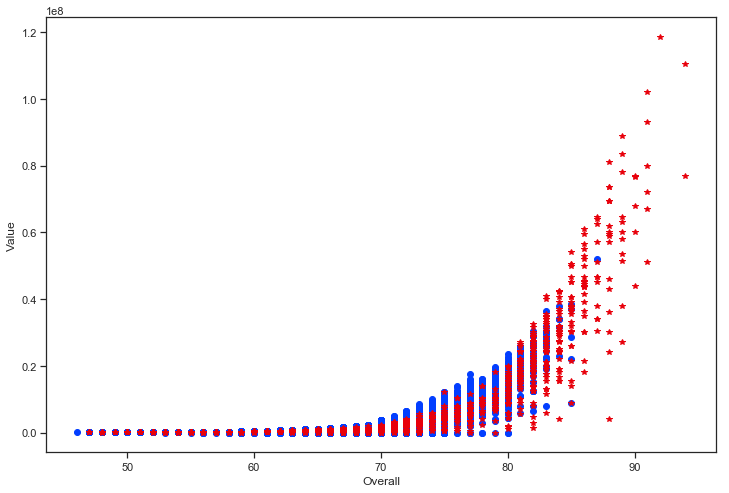

In [128]:
# Plot Inliner and Outlier - Overall against Value
plt.figure(figsize = (12,8))
plt.plot(fifa_ad[fifa_ad['anomaly_if']==1].Overall,fifa_ad[fifa_ad['anomaly_if']==1].Value,'bo')
plt.plot(fifa_ad[fifa_ad['anomaly_if']==-1].Overall,fifa_ad[fifa_ad['anomaly_if']==-1].Value,'r*')
plt.xlabel('Overall')
plt.ylabel('Value')
plt.show()

**Plot anomaly data by POSITION**

*Lets check how this model classifies players by 1st look at the players'position*|

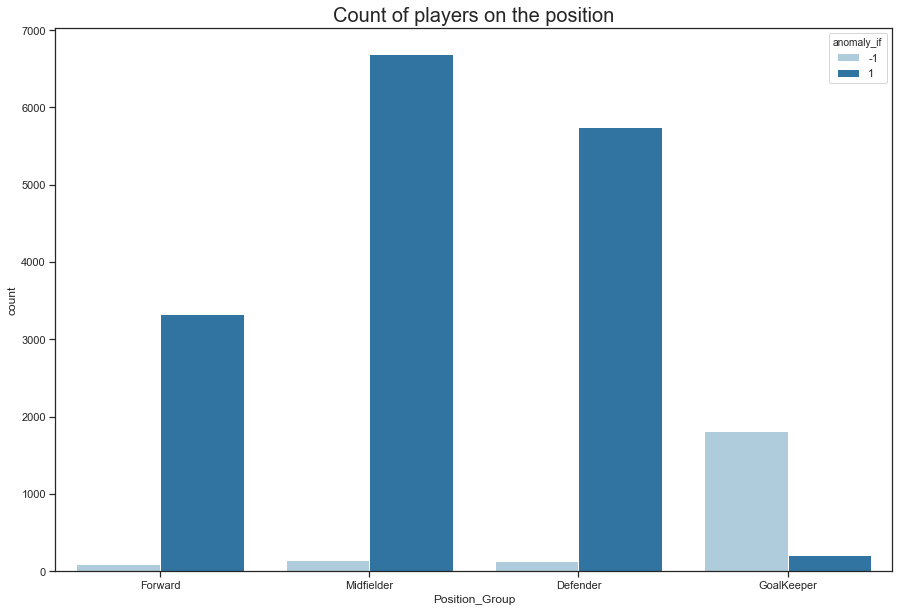

In [129]:
f, ax = plt.subplots(figsize=(15, 10))

ax = sns.countplot(x = 'Position_Group', data = fifa_ad,
                   order = ['Forward', 'Midfielder', 'Defender', 'GoalKeeper'], hue = 'anomaly_if',palette="Paired")

ax.set_title(label='Count of players on the position', fontsize=20);

/Users/tammy/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning:

Using the stripplot function without specifying `order` is likely to produce an incorrect plot.



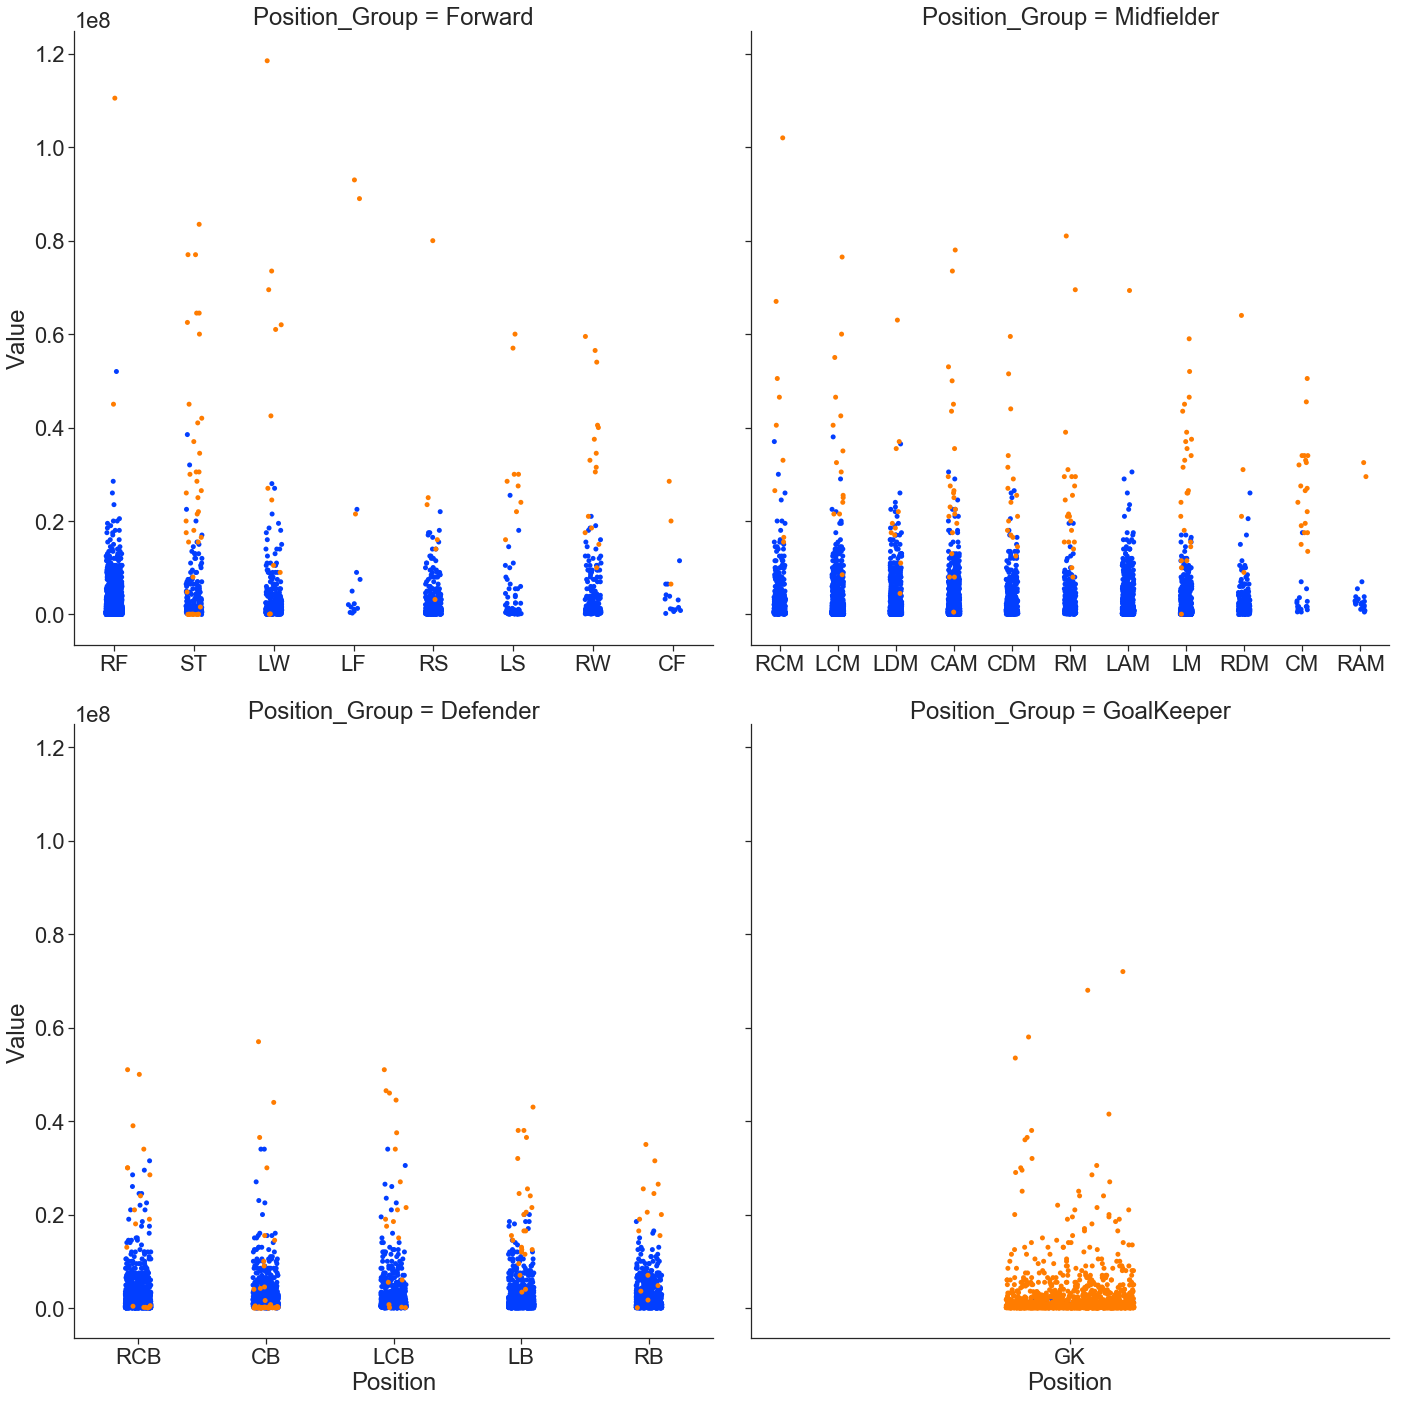

In [130]:
sns.set(font_scale=2, style ="ticks", palette = 'bright', color_codes=True)

g = sns.FacetGrid(fifa_ad, col="Position_Group", hue = 'anomaly_if',
                  hue_order = [1,-1],
                  col_order = ['Forward', 'Midfielder', 'Defender', 'GoalKeeper']
                  ,sharex=False, sharey=True, col_wrap=2, height=10)

g.map(sns.stripplot, 'Position' ,"Value" )

sns.set(font_scale=1, style ="ticks", palette = 'bright', color_codes=True)

## GoalKeeper

In [131]:
anomaly_gk_scaled.shape

(2026, 67)

In [132]:
anomaly_gk_scaled.columns[65]

'Position_Group_GoalKeeper'

In [133]:
to_model_columns=anomaly_gk_scaled.columns[0:64]
clf=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12), \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=119, verbose=0)
clf.fit(anomaly_gk_scaled[to_model_columns])
pred = clf.predict(anomaly_gk_scaled[to_model_columns])

fifa_gk['anomaly_if']=pred
outliers=fifa_gk.loc[fifa_gk['anomaly_if']==-1]
outlier_index=list(outliers.index)
#print(outlier_index)
#Find the number of anomalies and normal points here points classified -1 are anomalous
print(fifa_gk['anomaly_if'].value_counts())

/Users/tammy/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



 1    1783
-1     243
Name: anomaly_if, dtype: int64


/Users/tammy/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.



Text(0.5, 1.0, 'Overall Distribution by Anomaly')

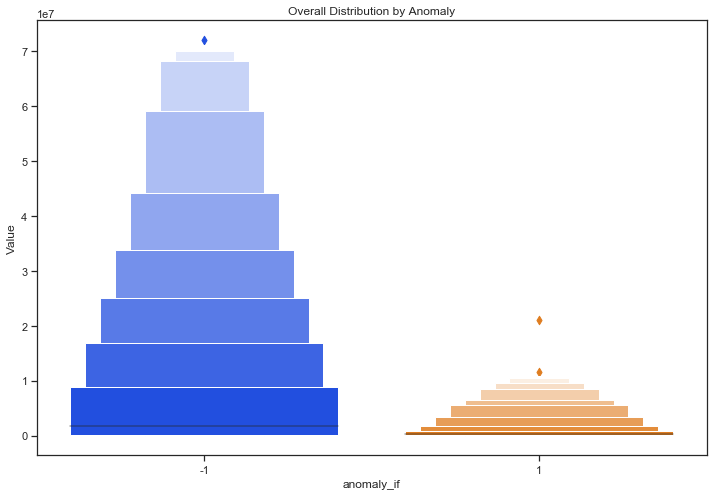

In [134]:
plt.figure(figsize = (12,8))


ax = sns.boxenplot(x= 'anomaly_if', y= 'Value', data = fifa_gk, scale = 'linear')

ax.set_title('Overall Distribution by Anomaly')


/Users/tammy/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning:

Using the stripplot function without specifying `order` is likely to produce an incorrect plot.



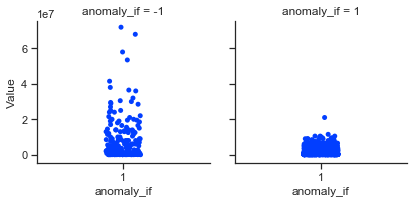

In [136]:
sns.set(font_scale=1, style ="ticks", palette = 'bright', color_codes=True)
g = sns.FacetGrid(fifa_gk, col="anomaly_if")

g.map(sns.stripplot, 'anomaly_if' ,"Value" )

In [137]:
fifa_gk[fifa_gk['anomaly_if']==-1].sort_values(by=['Value'],ascending=False)

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,Club_Reputation,Attack_WR,Defense_WR,Position_Group,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Continent,anomaly_svm,anomaly_if
3,3,De Gea,27,Spain,91,93,Manchester United,72000000.0,260000.0,1471,1,4.0,3.0,1.0,Lean,1,GK,1.0,2741,0,2,193,168,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,138600000.0,2.090909,Medium,Medium,GoalKeeper,0,22.8,30.2,61.6,43.4,42.666667,16.333333,88.8,2,Europe,1,-1
9,9,J. Oblak,25,Slovenia,90,93,Atlético Madrid,68000000.0,94000.0,1331,1,3.0,3.0,1.0,Normal,1,GK,1.0,1630,0,3,188,192,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13.0,11.0,15.0,29.0,13.0,12.0,13.0,14.0,26.0,16.0,43.0,60.0,67.0,86.0,49.0,22.0,76.0,41.0,78.0,12.0,34.0,19.0,11.0,70.0,11.0,70.0,27.0,12.0,18.0,86.0,92.0,78.0,88.0,89.0,144500000.0,1.878788,Medium,Medium,GoalKeeper,0,16.2,16.2,61.0,45.8,35.833333,19.000000,86.6,3,Europe,1,-1
18,18,M. ter Stegen,26,Germany,89,92,FC Barcelona,58000000.0,240000.0,1328,1,3.0,4.0,1.0,Normal,1,GK,22.0,1645,0,4,188,187,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15.0,14.0,11.0,36.0,14.0,17.0,18.0,12.0,42.0,18.0,38.0,50.0,37.0,85.0,43.0,22.0,79.0,35.0,79.0,10.0,43.0,22.0,11.0,69.0,25.0,69.0,25.0,13.0,10.0,87.0,85.0,88.0,85.0,90.0,123300000.0,2.242424,Medium,Medium,GoalKeeper,0,18.0,21.4,50.6,45.0,39.833333,16.000000,87.0,3,Europe,1,-1
19,19,T. Courtois,26,Belgium,89,90,Real Madrid,53500000.0,240000.0,1311,0,4.0,2.0,1.0,Normal,1,GK,1.0,145,0,6,198,212,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14.0,14.0,13.0,33.0,12.0,13.0,19.0,20.0,35.0,23.0,46.0,52.0,61.0,84.0,45.0,36.0,68.0,38.0,70.0,17.0,23.0,15.0,13.0,44.0,27.0,66.0,20.0,18.0,16.0,85.0,91.0,72.0,86.0,88.0,113700000.0,2.090909,Medium,Medium,GoalKeeper,0,17.2,22.0,57.6,45.8,31.333333,18.000000,84.4,1,Europe,1,-1
57,57,Ederson,24,Brazil,86,90,Manchester City,41500000.0,125000.0,1463,0,2.0,3.0,1.0,Normal,1,GK,31.0,549,0,7,188,190,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20.0,14.0,14.0,56.0,18.0,23.0,15.0,20.0,58.0,37.0,64.0,63.0,60.0,86.0,48.0,42.0,58.0,41.0,68.0,18.0,35.0,25.0,20.0,67.0,17.0,70.0,28.0,15.0,8.0,85.0,80.0,91.0,82.0,87.0,79900000.0,2.090909,Medium,Medium,GoalKeeper,0,24.4,30.6,64.2,45.4,39.000000,17.000000,85.0,4,South America,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16888,16936,Y. Uekusa,35,Japan,56,56,Shimizu S-Pulse,20000.0,1000.0,1303,1,1.0,2.0,1.0,Normal,0,GK,43.0,914,0,3,185,176,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35.0,16.0,28.0,46.0,13.0,13.0,37.0,19.0,66.0,35.0,63.0,60.0,61.0,65.0,56.0,40.0,54.0,44.0,54.0,18.0,45.0,16.0,15.0,48.0,33.0,34.0,10.0,23.0,17.0,46.0,48.0,59.0,55.0,65.0,25000.0,1.033333,Medium,Medium,GoalKeeper,0,27.6,34.0,61.0,42.0,31.833333,16.666667,54.6,0,Asia,1,-1
16006,16054,K. Fegrouche,36,Moroc

In [138]:
fifa_gk[fifa_gk['anomaly_if']==1].sort_values(by=['Value'],ascending=False)

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,Club_Reputation,Attack_WR,Defense_WR,Position_Group,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Continent,anomaly_svm,anomaly_if
197,197,O. Baumann,28,Germany,83,84,TSG 1899 Hoffenheim,21000000.0,42000.0,1222,1,2.0,1.0,1.0,Normal,0,GK,1.0,1645,0,3,188,181,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14.0,11.0,16.0,30.0,11.0,19.0,12.0,11.0,25.0,17.0,47.0,51.0,45.0,81.0,43.0,21.0,73.0,39.0,69.0,13.0,32.0,21.0,10.0,41.0,22.0,52.0,15.0,18.0,14.0,82.0,82.0,70.0,82.0,85.0,37300000.0,1.363636,Medium,Medium,GoalKeeper,0,16.4,16.8,53.4,43.0,29.666667,15.666667,80.2,1,Europe,1,1
609,609,Sergio Rico,24,Spain,79,83,Fulham,11500000.0,13000.0,1204,1,2.0,3.0,1.0,Lean,1,GK,25.0,0,1,1,193,194,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17.0,14.0,11.0,28.0,15.0,14.0,24.0,20.0,26.0,12.0,48.0,46.0,62.0,76.0,43.0,19.0,63.0,36.0,54.0,12.0,27.0,19.0,11.0,53.0,24.0,60.0,16.0,11.0,11.0,77.0,78.0,77.0,79.0,81.0,0.0,1.156250,Medium,Medium,GoalKeeper,0,17.0,19.2,55.0,36.8,32.333333,12.666667,78.4,4,Europe,-1,1
512,512,P. Gulácsi,28,Hungary,80,80,RB Leipzig,10500000.0,45000.0,1223,1,2.0,2.0,1.0,Normal,0,GK,1.0,1280,0,4,193,190,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16.0,10.0,23.0,29.0,10.0,19.0,18.0,11.0,25.0,25.0,42.0,44.0,41.0,72.0,50.0,23.0,67.0,35.0,68.0,12.0,34.0,23.0,11.0,36.0,24.0,45.0,25.0,16.0,20.0,81.0,80.0,76.0,76.0,81.0,17900000.0,1.357143,Medium,Medium,GoalKeeper,0,17.6,19.6,49.8,41.0,28.833333,20.333333,78.8,0,Europe,1,1
1544,1544,A. Lunin,19,Ukraine,76,88,CD Leganés,10500000.0,24000.0,1078,1,1.0,3.0,1.0,Normal,0,GK,29.0,0,1,1,190,176,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15.0,8.0,12.0,25.0,12.0,11.0,14.0,15.0,26.0,15.0,33.0,26.0,36.0,76.0,22.0,22.0,56.0,32.0,61.0,7.0,22.0,19.0,11.0,60.0,19.0,56.0,22.0,13.0,11.0,74.0,71.0,76.0,77.0,79.0,0.0,1.151515,Medium,Medium,GoalKeeper,0,14.4,16.2,38.6,35.6,31.166667,15.333333,75.4,12,Europe,-1,1
819,819,A. Cragno,24,Italy,78,84,Cagliari,10500000.0,21000.0,1150,1,1.0,3.0,1.0,Lean,0,GK,12.0,1634,0,4,183,172,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15.0,12.0,12.0,26.0,13.0,13.0,11.0,12.0,25.0,21.0,41.0,37.0,37.0,62.0,43.0,19.0,74.0,43.0,55.0,17.0,33.0,19.0,15.0,42.0,31.0,59.0,20.0,11.0,12.0,82.0,76.0,60.0,76.0,85.0,20000000.0,1.541667,Medium,Medium,GoalKeeper,0,15.6,16.4,44.0,41.6,33.166667,14.333333,75.8,6,Europe,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4707,4707,E. Conde,35,Uruguay,71,71,No_Club,0.0,6927.0,994,1,1.0,3.0,1.0,Normal,0,GK,23.0,0,0,0,188,187,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20.0,12.0,12.0,19.0,12.0,13.0,19.0,23.0,25.0,21.0,36.0,26.0,29.0,68.0,31.0,12.0,33.0,28.0,26.0,13.0,33.0,26.0,12.0,42.0,17.0,38.0,18.0,11.0,11.0,71.0,72.0,62.0,71.0,70.0,0.0,1.062241,Medium,Medium,GoalKeeper,0,15.0,20.2,38.0,22.4,28.000000,13.333333,69.2,0,South America,-1,1
3736,3736,D. Dibusz,27,Hungary,72,73,No_Club,0.0,31214.0,947,1,1.0,3.0,1.0,Normal,

---

## 3. `MODEL 3: LocalOutLierFactor` 

The LOF is a calculation that looks at the neighbors of a certain point to find out its density and compare this to the density of other points later on (relies on nearest neighbours search).

**k-distance:**
The distance of a point to its kth neighbor

**Reachability distance:**
reach-dist(a,b) = max{k-distance(b), dist(a,b)}

**Local reachability density:**
Tells us how far we have to travel from our point to reach the next point or cluster of point.

lrd(a) = 1/(sum(reach-dist(a,n))/k)

**Local Outlier Factor:**
Tells how likely a certain data point is an outlier/anomaly. 

k ratios of the lrd of each point to its neighboring points will be calculated and averaged. The LOF is basically the average ratio of the lrds of the neighbors of a to the lrd of a. 

    LOF ≈1 ⇒ no outlier
    LOF ≫1 ⇒ outlier

But based on the actual data set, it may be varied.

### `MODEL 3.1 - USING MANHATTAN DISTANCE`

In [85]:
from sklearn.neighbors import LocalOutlierFactor

In [86]:
clf = LocalOutlierFactor(n_neighbors=2,metric='manhattan')
pred_of = clf.fit_predict(anomaly_scaled)
scores = clf.negative_outlier_factor_
scores_of = -scores # Turn negative number to positive number

/Users/tammy/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



In [87]:
print(scores_of.min())
print(scores_of.max())
print(scores_of.mean())
print(scores_of.std())

0.8572537011157678
2.0388036710670043
1.1053734981035173
0.11235117018206202


In [118]:
normal_of = fifa_ad[scores_of < scores_of.mean()+scores_of.std()*2]
abnormal_of = fifa_ad[scores_of >= scores_of.mean()+scores_of.std()*2]

fifa_ad['scores_of'] = scores_of

for index, row in fifa_sd.loc[fifa_ad['scores_of'] == 0, ['svm_ofm', 'Overall']].iterrows():
  if row[1] <= 62:
    fifa.loc[index, 'Wage'] = round(wage_groups[0])
    
    fifa_ad['svm_ofm'] = 1
else: fifa_ad['svm_ofm'] = -1
    
#fifa_ad['anomaly_ofm']= pred_gk
#outliers=fifa_gk.loc[fifa_gk['anomaly_svm']==-1]
#outlier_index=list(outliers.index)

#Find the number of anomalies and normal points here points classified -1 are anomalous
#print(fifa_gk['anomaly_svm'].value_counts())

KeyError: "None of [Float64Index([1.0172964313868764,  1.183769745818994, 1.0067695566745911,\n               1.204631635140384, 1.0776466565625886, 0.9935572534342082,\n              1.0254601308630038, 1.2804205365446077,  1.239950979723935,\n               1.094675832850517,\n              ...\n               1.012771356305216, 1.0854189087062753, 1.2062861152818605,\n              1.2862154615609314, 1.3480083436859025,  0.960671049762535,\n              1.4302516849531797, 0.9894232165066108, 0.9696210644249605,\n               1.016419895614962],\n             dtype='float64', length=18159)] are in the [columns]"

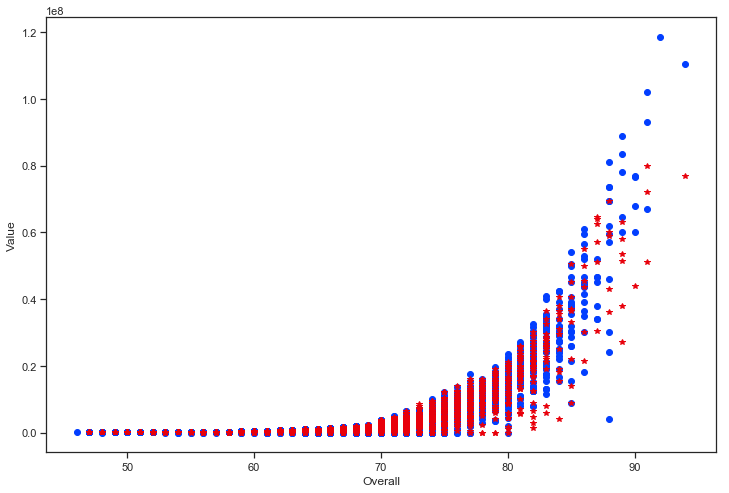

In [110]:
plt.figure(figsize = (12,8))
plt.plot(normal_of.Overall,normal_of.Value,'bo')
plt.plot(abnormal_of.Overall,abnormal_of.Value,'r*')
plt.xlabel('Overall')
plt.ylabel('Value')
plt.show()

In [68]:
normal_OF[normal_OF['Position_Group']== 'Forward']

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,Club_Reputation,Attack_WR,Defense_WR,Position_Group,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Continent
0,0,L. Messi,31,Argentina,94,94,FC Barcelona,110500000.0,565000.0,2202,0,5.0,4.0,4.0,Lean,1,RF,10.0,5297,0,3,170,159,88,88,88,92,93,93,93,92,93,93,93,91,84,84,84,91,64,61,61,61,64,59,47,47,47,59,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,226500000.0,2.242424,Medium,Medium,Forward,2,85.0,93.4,91.6,75.6,71.500000,29.000000,10.8,0,South America
1,1,Cristiano Ronaldo,33,Portugal,94,94,Juventus,77000000.0,405000.0,2228,1,5.0,4.0,5.0,Normal,1,ST,7.0,175,0,4,188,183,91,91,91,89,90,90,90,89,88,88,88,88,81,81,81,88,65,61,61,61,65,61,53,53,53,61,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,127100000.0,2.520000,High,Low,Forward,3,87.0,83.2,86.6,90.0,74.833333,27.333333,11.6,0,Europe
2,2,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,118500000.0,290000.0,2143,1,5.0,5.0,5.0,Lean,1,LW,10.0,516,0,4,175,150,84,84,84,89,89,89,89,89,89,89,89,88,81,81,81,88,65,60,60,60,65,60,47,47,47,60,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,228100000.0,2.233333,High,Medium,Forward,3,79.2,88.8,91.6,70.6,73.833333,28.000000,11.8,1,South America
5,5,E. Hazard,27,Belgium,91,91,Chelsea,93000000.0,340000.0,2142,1,4.0,4.0,4.0,Normal,1,LF,10.0,2375,0,2,173,163,83,83,83,89,88,88,88,89,89,89,89,89,82,82,82,89,66,63,63,63,66,60,49,49,49,60,81.0,84.0,61.0,89.0,80.0,95.0,83.0,79.0,83.0,94.0,94.0,88.0,95.0,90.0,94.0,82.0,56.0,83.0,66.0,80.0,54.0,41.0,87.0,89.0,86.0,91.0,34.0,27.0,22.0,11.0,12.0,6.0,8.0,8.0,172100000.0,2.121212,High,Medium,Forward,3,79.0,86.8,92.2,73.4,74.666667,27.666667,9.0,0,Europe
10,10,R. Lewandowski,29,Poland,90,90,FC Bayern München,77000000.0,205000.0,2152,1,4.0,4.0,4.0,Normal,1,ST,9.0,1645,0,3,183,176,87,87,87,83,86,86,86,83,83,83,83,81,77,77,77,81,61,62,62,62,61,58,57,57,57,58,62.0,91.0,85.0,83.0,89.0,85.0,77.0,86.0,65.0,89.0,77.0,78.0,78.0,90.0,78.0,88.0,84.0,78.0,84.0,84.0,80.0,39.0,91.0,77.0,88.0,86.0,34.0,42.0,19.0,15.0,6.0,12.0,8.0,10.0,127100000.0,2.517241,High,Medium,Forward,3,82.0,80.4,80.2,83.6,76.833333,31.666667,10.2,0,Europe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18118,18166,N. Ayéva,16,Sweden,48,72,Örebro SK,70000.0,1000.0,1286,1,1.0,3.0,2.0,Normal,0,ST,23.0,228,0,2,178,154,47,47,47,48,47,47,47,48,47,47,47,47,41,41,41,47,36,32,32,32,36,34,30,30,30,34,34.0,47.0,42.0,43.0,40.0,50.0,45.0,32.0,30.0,46.0,65.0,66.0,63.0,45.0,74.0,45.0,81.0,58.0,52.0,43.0,26.0,18.0,42.0,50.0,60.0,44.0,14.0,19.0,16.0,10.0,9.0,8.0,7.0,6.0,158000.0,1.000000,Medium,Medium,Forward,2,41.2,40.6,62.6,55.8,40.00

In [69]:
abnormal_OF[abnormal_OF['Position_Group']== 'Forward']

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,Club_Reputation,Attack_WR,Defense_WR,Position_Group,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Continent
7,7,L. Suárez,31,Uruguay,91,91,FC Barcelona,80000000.0,455000.0,2346,1,5.0,4.0,3.0,Normal,1,RS,9.0,1635,0,3,183,190,87,87,87,86,87,87,87,86,85,85,85,84,79,79,79,84,69,68,68,68,69,66,63,63,63,66,77.0,93.0,77.0,82.0,88.0,87.0,86.0,84.0,64.0,90.0,86.0,75.0,82.0,92.0,83.0,86.0,69.0,90.0,83.0,85.0,87.0,41.0,92.0,84.0,85.0,85.0,62.0,45.0,38.0,27.0,25.0,31.0,33.0,37.0,164000000.0,2.242424,High,Medium,Forward,5,83.4,82.2,83.6,82.6,79.000000,48.333333,30.6,0,South America
76,76,Iniesta,34,Spain,86,86,Vissel Kobe,21500000.0,21000.0,2058,1,4.0,4.0,4.0,Normal,1,LF,8.0,169,0,3,170,150,74,74,74,82,81,81,81,82,85,85,85,82,83,83,83,82,71,73,73,73,71,68,63,63,63,68,77.0,70.0,54.0,90.0,74.0,90.0,80.0,70.0,85.0,92.0,70.0,67.0,79.0,86.0,84.0,65.0,47.0,55.0,58.0,71.0,58.0,66.0,81.0,93.0,71.0,89.0,67.0,57.0,56.0,6.0,13.0,6.0,13.0,7.0,26900000.0,1.200000,High,Medium,Forward,3,73.0,83.4,77.2,59.2,76.333333,60.000000,9.0,0,Europe
109,109,Z. Ibrahimović,36,Sweden,85,85,LA Galaxy,14000000.0,15000.0,2012,1,5.0,4.0,5.0,Normal,1,RS,9.0,284,0,4,196,209,82,82,82,77,80,80,80,77,79,79,79,76,73,73,73,76,55,57,57,57,55,51,52,52,52,51,73.0,86.0,83.0,79.0,86.0,79.0,82.0,82.0,73.0,84.0,58.0,59.0,75.0,82.0,39.0,90.0,68.0,61.0,86.0,82.0,84.0,20.0,85.0,79.0,89.0,90.0,28.0,37.0,24.0,13.0,15.0,10.0,9.0,12.0,21000000.0,1.400000,Medium,Low,Forward,4,81.4,80.0,62.6,77.4,74.500000,29.666667,11.8,0,Europe
139,139,M. Mandžukić,32,Croatia,84,84,Juventus,25000000.0,160000.0,2106,1,3.0,3.0,3.0,Lean,1,ST,17.0,1280,0,2,190,187,81,81,81,76,78,78,78,76,76,76,76,76,75,75,75,76,71,72,72,72,71,71,72,72,72,71,72.0,84.0,90.0,75.0,86.0,76.0,64.0,49.0,67.0,77.0,67.0,73.0,67.0,86.0,53.0,80.0,85.0,83.0,85.0,60.0,88.0,66.0,90.0,74.0,76.0,80.0,59.0,64.0,64.0,10.0,8.0,5.0,8.0,15.0,41300000.0,2.520000,High,High,Forward,3,81.4,66.6,69.2,78.6,79.000000,62.333333,9.2,0,Europe
204,204,B. Dost,29,Netherlands,83,83,Sporting CP,26000000.0,26000.0,1793,1,3.0,3.0,2.0,Lean,0,ST,28.0,856,0,3,196,196,80,80,80,68,75,75,75,68,70,70,70,67,67,67,67,67,54,57,57,57,54,53,57,57,57,53,38.0,87.0,94.0,73.0,85.0,68.0,61.0,30.0,37.0,74.0,49.0,54.0,32.0,85.0,32.0,82.0,51.0,82.0,92.0,72.0,70.0,39.0,89.0,68.0,88.0,81.0,38.0,45.0,26.0,6.0,12.0,15.0,11.0,8.0,52000000.0,1.533333,Medium,Medium,Forward,3,75.4,54.0,50.4,75.8,72.500000,36.333333,10.4,0,Europe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18003,18051,C. Björk,18,Sweden,50,70,IFK Norrköping,60000.0,1000.0,1282,1,1.0,3.0,2.0,Normal,0,CF,32.0,365,0,4,183,163,49,49,49,48,50,50,50,48,50,50,50,48,46,46,46,48,34,34,34,34,34,32,28,28,28,32,30.0,49.0,46.0,52.0,43.0,46.0,46.0,37.0,41.0,45.0,63.0,60.0,52.0,47.0,60.0,49.0,64.0,55.0,55.0,46.0,25.0,18.0,47.0,64.0,60.0,43.0,12.0,12.0,10.0,12.0,11.0,6.0,13.0,6.0,135000.0,1.000000,High,Medium,Forward,2,44.0,43.0,56.4,53.8,42.833333,11.333333,9.6,20

In [60]:
abnormal_OF.describe()

,ID,Age,Overall,Potential,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Real Face,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,Club_Reputation,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference
count,2684.000000,2684.000000,2684.000000,2684.000000,2.684000e+03,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.00000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2.684000e+03,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000
mean,10006.358048,25.194858,65.100969,70.601341,1.943187e+06,8642.811475,1562.321162,0.743666,1.122578,2.906483,2.263413,0.097243,19.700075,767.464978,0.065946,2.099851,181.317437,166.256706,49.002981,49.002981,49.002981,50.042101,49.767884,49.767884,49.767884,50.042101,50.035022,50.035022,50.035022,50.650149,49.580477,49.580477,49.580477,50.650149,49.399776,48.966095,48.966095,48.966095,49.399776,48.914307,48.214978,48.214978,48.214978,48.914307,47.819300,43.380402,50.539493,57.23696,40.432563,53.251118,45.406483,41.330104,51.488077,56.503353,62.744411,62.843517,61.896423,60.634501,62.745902,53.789866,63.752608,60.972429,64.616990,45.081595,54.868107,46.618480,47.772355,52.007079,46.899031,56.794337,46.880775,47.766021,45.643815,17.626677,17.332340,17.288748,17.442996,17.769001,3.350664e+06,1.127859,1.758569,47.881744,49.595827,62.172951,57.642697,50.826565,46.763537,17.491952,5.500373
std,5272.780157,5.187182,6.978580,6.564836,4.929656e+06,21860.069714,269.621038,0.436690,0.426774,0.770188,0.752872,0.296343,15.267933,888.041739,0.248235,1.339951,7.510498,17.424563,20.792570,20.792570,20.792570,21.441582,21.338271,21.338271,21.338271,21.441582,21.456895,21.456895,21.456895,21.461165,21.035862,21.035862,21.035862,21.461165,20.995004,21.209934,21.209934,21.209934,20.995004,20.989662,21.480334,21.480334,21.480334,20.989662,18.888962,19.559352,17.957717,15.21408,17.544223,19.401584,18.604356,17.958617,15.727443,17.191615,15.979822,15.724144,15.656645,9.460994,15.471695,17.535072,13.401589,17.031946,14.049461,19.402433,18.050487,20.552863,19.821453,14.672177,15.937233,12.059958,19.809434,21.611684,21.199666,18.980147,18.140952,17.925543,18.278484,19.331685,9.447450e+06,0.248866,0.700235,14.886339,15.915780,11.553092,11.284044,12.479732,20.268565,18.310327,5.802984
min,7.000000,16.000000,47.000000,48.000000,0.000000e+00,1000.000000,757.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,155.000000,110.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00

In [111]:
abnormal_of.shape

(7276, 99)

In [112]:
normal_of.shape

(10883, 99)

/Users/tammy/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning:

Using the stripplot function without specifying `order` is likely to produce an incorrect plot.



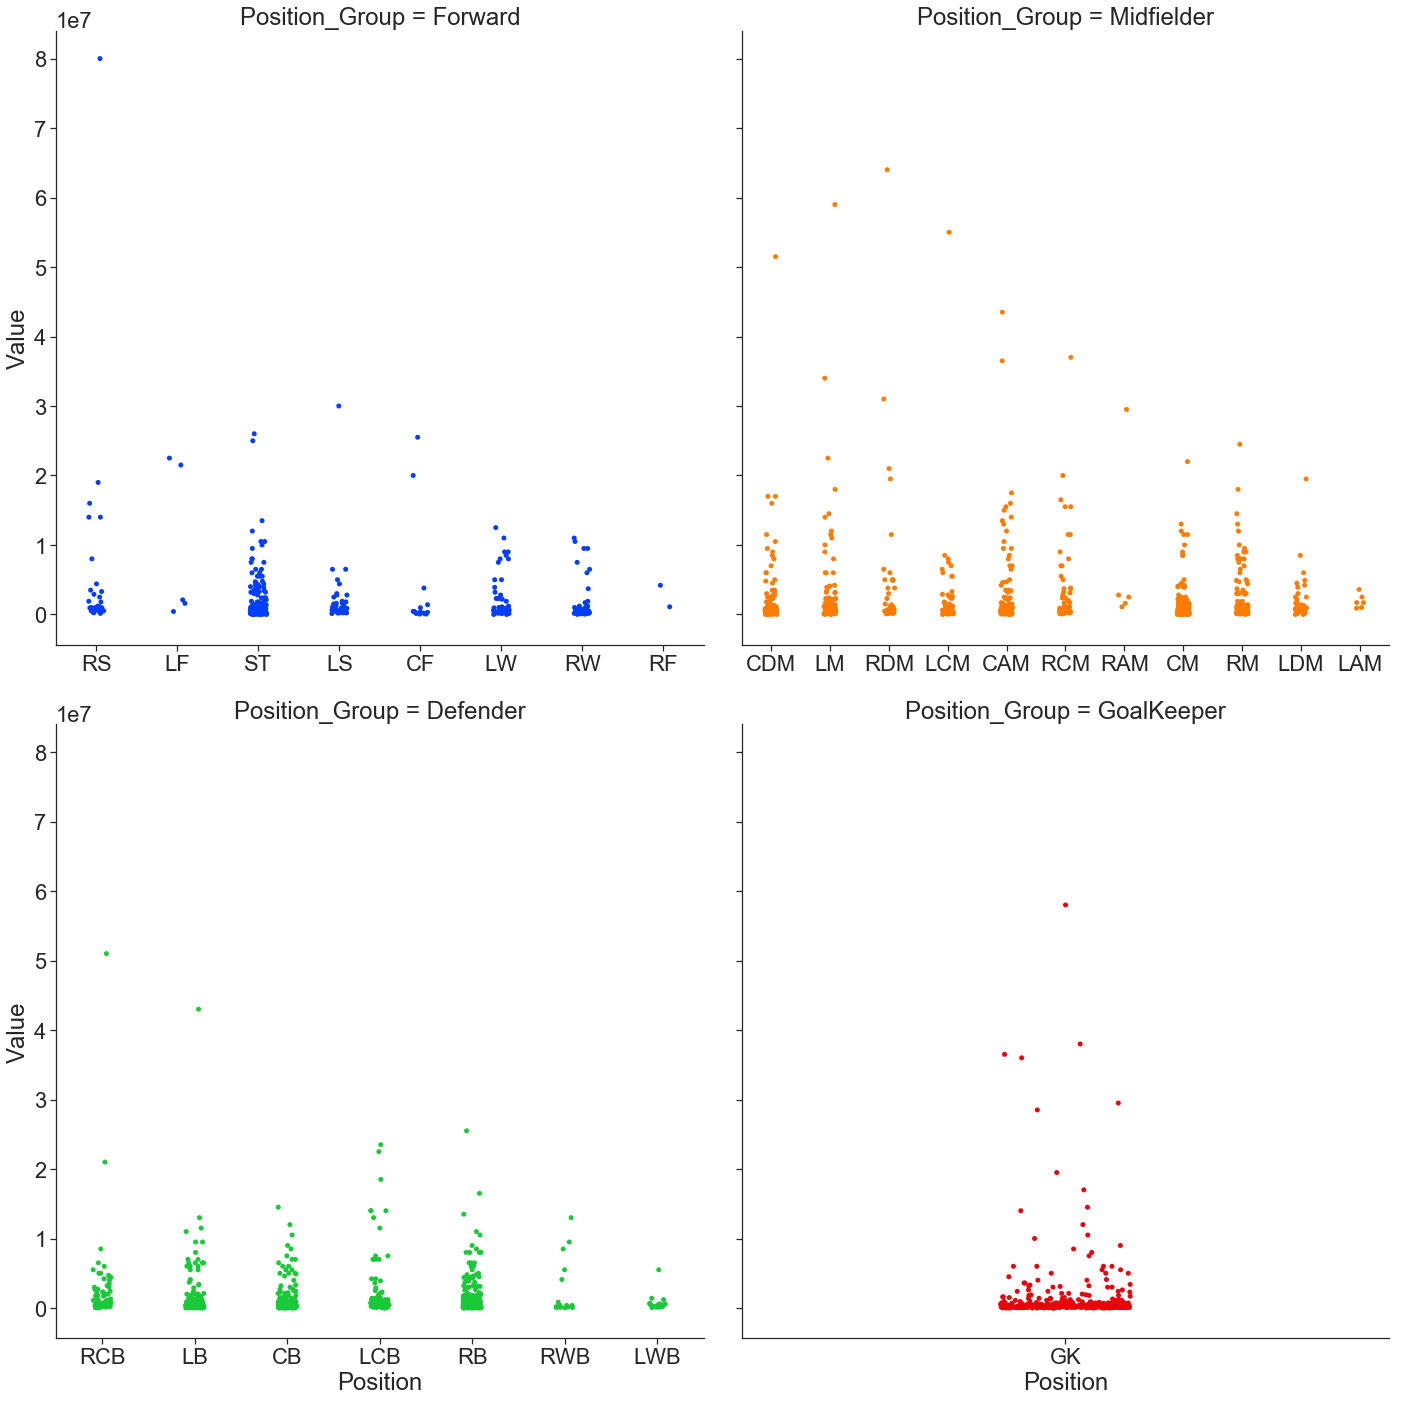

In [70]:
sns.set(font_scale=2, style ="ticks", palette = 'bright', color_codes=True)

g = sns.FacetGrid(abnormal_OF, col="Position_Group", hue = 'Position_Group',
                  hue_order= ['Forward', 'Midfielder', 'Defender', 'GoalKeeper'],
                  col_order = ['Forward', 'Midfielder', 'Defender', 'GoalKeeper']
                  ,sharex=False, sharey=True, col_wrap=2, height=10)

g.map(sns.stripplot, 'Position' ,"Value" )

sns.set(font_scale=1, style ="ticks", palette = 'bright', color_codes=True)

### `MODEL 3.2 - USING EUCLIDEAN DISTANCE`

In [71]:
clf = LocalOutlierFactor(n_neighbors=2,metric='euclidean')
y_pred = clf.fit_predict(anomaly_scaled)
scores_eud = clf.negative_outlier_factor_
scores_of_eud = -scores_eud # Turn negative number to positive number

/Users/tammy/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



In [72]:
normal_OF_eud = fifa[scores_of_eud < scores_of_eud.mean()+scores_of_eud.std()]
abnormal_OF_eud = fifa[scores_of_eud >= scores_of_eud.mean()+scores_of_eud.std()]

In [ ]:
# Decribe the score
print(scores_of_edu.min())
print(scores_of_edu.max())
print(scores_of_edu.mean())
print(scores_of_edu.std())

In [87]:
abnormal_OF_eud.shape

(2714, 98)

In [88]:
normal_OF_eud.shape

(15445, 98)

In [73]:
abnormal_OF_eud.head()

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,Club_Reputation,Attack_WR,Defense_WR,Position_Group,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Continent
4,4,K. De Bruyne,27,Belgium,91,92,Manchester City,102000000.0,355000.0,2281,1,4.0,5.0,4.0,Normal,1,RCM,7.0,1220,0,5,180,154,82,82,82,87,87,87,87,87,88,88,88,88,87,87,87,88,77,77,77,77,77,73,66,66,66,73,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,196400000.0,2.090909,High,High,Midfielder,3,80.8,87.2,80.2,82.0,80.833333,59.000000,11.2,1,Europe
22,22,M. Neuer,32,Germany,89,89,FC Bayern München,38000000.0,130000.0,1473,1,5.0,4.0,1.0,Normal,1,GK,1.0,2741,0,3,193,203,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15.0,13.0,25.0,55.0,11.0,30.0,14.0,11.0,59.0,48.0,54.0,60.0,51.0,84.0,35.0,25.0,77.0,43.0,80.0,16.0,29.0,30.0,12.0,70.0,47.0,70.0,17.0,10.0,11.0,90.0,86.0,91.0,87.0,87.0,62700000.0,2.517241,Medium,Medium,GoalKeeper,0,23.8,32.4,56.8,48.2,43.000000,12.666667,88.2,0,Europe
35,35,Marcelo,30,Brazil,88,88,Real Madrid,43000000.0,285000.0,2279,0,4.0,4.0,5.0,Normal,1,LB,12.0,4383,0,4,175,176,80,80,80,84,83,83,83,84,84,84,84,85,84,84,84,85,85,83,83,83,85,84,81,81,81,84,90.0,70.0,75.0,84.0,54.0,90.0,85.0,67.0,76.0,92.0,83.0,82.0,86.0,88.0,86.0,83.0,76.0,91.0,78.0,70.0,84.0,85.0,85.0,82.0,59.0,86.0,71.0,85.0,86.0,12.0,5.0,5.0,5.0,9.0,88200000.0,2.090909,High,Low,Defender,3,74.6,82.0,85.0,79.6,80.166667,80.666667,7.2,0,South America
37,37,H. Lloris,31,France,88,88,Tottenham Hotspur,36000000.0,150000.0,1335,0,4.0,1.0,1.0,Lean,1,GK,1.0,2344,0,4,188,181,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13.0,10.0,10.0,50.0,11.0,10.0,11.0,10.0,50.0,34.0,65.0,62.0,55.0,85.0,54.0,23.0,74.0,41.0,43.0,14.0,31.0,27.0,10.0,30.0,40.0,65.0,29.0,10.0,18.0,88.0,84.0,68.0,83.0,92.0,66600000.0,2.000000,Medium,Medium,GoalKeeper,0,18.8,23.0,64.2,39.0,33.833333,19.000000,83.0,0,Europe
44,44,K. Koulibaly,27,Senegal,87,90,Napoli,51000000.0,115000.0,1660,1,3.0,3.0,2.0,Normal,1,LCB,26.0,1645,0,3,188,196,52,52,52,51,52,52,52,51,52,52,52,55,58,58,58,55,71,75,75,75,71,75,84,84,84,75,30.0,19.0,81.0,66.0,14.0,66.0,28.0,28.0,56.0,60.0,68.0,75.0,50.0,80.0,40.0,55.0,81.0,71.0,94.0,15.0,87.0,88.0,24.0,43.0,33.0,78.0,91.0,88.0,86.0,7.0,11.0,7.0,13.0,5.0,90500000.0,2.160000,High,High,Defender,3,42.0,47.6,62.6,63.2,58.833333,88.333333,8.6,3,Africa


In [75]:
normal_OF_eud.head(100)

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,Club_Reputation,Attack_WR,Defense_WR,Position_Group,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Continent
0,0,L. Messi,31,Argentina,94,94,FC Barcelona,110500000.0,565000.0,2202,0,5.0,4.0,4.0,Lean,1,RF,10.0,5297,0,3,170,159,88,88,88,92,93,93,93,92,93,93,93,91,84,84,84,91,64,61,61,61,64,59,47,47,47,59,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,226500000.0,2.242424,Medium,Medium,Forward,2,85.0,93.4,91.6,75.6,71.500000,29.000000,10.8,0,South America
1,1,Cristiano Ronaldo,33,Portugal,94,94,Juventus,77000000.0,405000.0,2228,1,5.0,4.0,5.0,Normal,1,ST,7.0,175,0,4,188,183,91,91,91,89,90,90,90,89,88,88,88,88,81,81,81,88,65,61,61,61,65,61,53,53,53,61,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,127100000.0,2.520000,High,Low,Forward,3,87.0,83.2,86.6,90.0,74.833333,27.333333,11.6,0,Europe
2,2,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,118500000.0,290000.0,2143,1,5.0,5.0,5.0,Lean,1,LW,10.0,516,0,4,175,150,84,84,84,89,89,89,89,89,89,89,89,88,81,81,81,88,65,60,60,60,65,60,47,47,47,60,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,228100000.0,2.233333,High,Medium,Forward,3,79.2,88.8,91.6,70.6,73.833333,28.000000,11.8,1,South America
3,3,De Gea,27,Spain,91,93,Manchester United,72000000.0,260000.0,1471,1,4.0,3.0,1.0,Lean,1,GK,1.0,2741,0,2,193,168,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,138600000.0,2.090909,Medium,Medium,GoalKeeper,0,22.8,30.2,61.6,43.4,42.666667,16.333333,88.8,2,Europe
5,5,E. Hazard,27,Belgium,91,91,Chelsea,93000000.0,340000.0,2142,1,4.0,4.0,4.0,Normal,1,LF,10.0,2375,0,2,173,163,83,83,83,89,88,88,88,89,89,89,89,89,82,82,82,89,66,63,63,63,66,60,49,49,49,60,81.0,84.0,61.0,89.0,80.0,95.0,83.0,79.0,83.0,94.0,94.0,88.0,95.0,90.0,94.0,82.0,56.0,83.0,66.0,80.0,54.0,41.0,87.0,89.0,86.0,91.0,34.0,27.0,22.0,11.0,12.0,6.0,8.0,8.0,172100000.0,2.121212,High,Medium,Forward,3,79.0,86.8,92.2,73.4,74.666667,27.666667,9.0,0,Europe
6,6,L. Modrić,32,Croatia,91,91,Real Madrid,67000000.0,420000.0,2280,1,4.0,4.0,4.0,Lean,1,RCM,10.0,2344,0,2,173,146,77,77,77,85,84,84,84,85,87,87,87,86,88,88,88,86,82,81,81,81,82,79,71,71,71,79,86.0,72.0,55.0,93.0,76.0,90.0,85.0,78.0,88.0,93.0,80.0,72.0,93.0,90.0,94.0,79.0,68.0,89.0,58.0,82.0,62.0,83.0,79.0,92.0,82.0,84.0,60.0,76.0,73.0,13.0,9.0,7.0,14.0,9.0,137400000.0,2.090909,High,High,Midfielder,3,76.4,86.8,85.8,75.2,80.333333,69.666667,10.4,0,Europe
7,7,L. Suárez,31,Uruguay,91,91,FC Barcelona,80000000.0,455000.0,2346,1,5.0,4.0,3.0,Normal,1,RS,9.0,1635,0,3,183,190,87,87,87,86,87,87,87,86,85,85,85,84,79,79,79,84,69,68,68,68,69,66,63,63,63,66,77.0,93.0,77.0,82.0,88.0,87.0,86.0,84.0,64.0,90.0,86.0,75.0,82.0,92.0,83.0,86.0,69.0,90.0,83.0,85.0,87.0,41.0,92.0,84.0,85.0,85.0,62.0,45.0,38.0,27.0,25.0,31.0,33.0,37.0,164000000.0,2.242424,High,Mediu

In [92]:
normal_OF_eud.Value.describe()

count    1.544500e+04
mean     2.472918e+06
std      5.595000e+06
min      0.000000e+00
25%      3.250000e+05
50%      7.250000e+05
75%      2.100000e+06
max      1.185000e+08
Name: Value, dtype: float64

### `MODEL 3.3 - USING COSINE DISTANCE`

In [76]:
clf = LocalOutlierFactor(n_neighbors=2,metric='cosine')
y_pred = clf.fit_predict(anomaly_scaled)
scores_cosine = clf.negative_outlier_factor_
scores_of_cosine = -scores_cosine # Turn negative number to positive number

/Users/tammy/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.



In [77]:
# Divide to normal and abnormal data set
normal_OF_cosine = fifa[scores_of_cosine < scores_of_cosine.mean()+scores_of_cosine.std()]
abnormal_OF_cosine = fifa[scores_of_cosine >= scores_of_cosine.mean()+scores_of_cosine.std()]

In [99]:
# Decribe the score
print(scores_of_cosine.min())
print(scores_of_cosine.max())
print(scores_of_cosine.mean())
print(scores_of_cosine.std())

0.80366238141381
4.369842573125033
1.2324600151866218
0.2572164728401088


In [79]:
abnormal_OF_cosine.shape

(2477, 98)

In [78]:
normal_OF_cosine.shape

(15682, 98)

In [80]:
abnormal_OF_cosine.describe()

,ID,Age,Overall,Potential,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Real Face,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,Club_Reputation,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference
count,2477.000000,2477.000000,2477.000000,2477.000000,2.477000e+03,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.00000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2.477000e+03,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000,2477.000000
mean,10712.980622,24.624950,64.227695,69.997578,1.569201e+06,6907.245862,1559.028664,0.736778,1.097699,2.892612,2.257570,0.076706,20.182883,713.562374,0.072265,2.068631,181.754138,166.291482,48.757771,48.757771,48.757771,49.785628,49.460234,49.460234,49.460234,49.785628,49.702463,49.702463,49.702463,50.413807,49.268470,49.268470,49.268470,50.413807,49.391199,48.848203,48.848203,48.848203,49.391199,48.982237,48.291885,48.291885,48.291885,48.982237,47.616472,43.212757,50.318934,56.680662,40.219217,52.908357,45.076706,41.08155,51.276948,55.888575,63.360920,63.414614,61.922487,59.798547,62.515139,53.346387,64.292289,61.379895,64.974566,44.784013,54.482842,46.805006,47.534921,51.704481,46.256762,56.018571,46.941461,48.215987,46.118692,17.540573,17.241421,17.163908,17.287444,17.729512,2.645328e+06,1.103160,1.756964,47.609608,49.246427,62.202342,57.755430,50.467097,47.092047,17.392572,5.769883
std,5006.472693,4.788271,6.550647,5.935504,4.420935e+06,17036.118578,263.665021,0.440471,0.371847,0.709227,0.717221,0.266178,15.826785,792.464818,0.258978,1.320635,6.556800,15.322088,20.504961,20.504961,20.504961,21.175694,21.053871,21.053871,21.053871,21.175694,21.186548,21.186548,21.186548,21.221891,20.784575,20.784575,20.784575,21.221891,20.692552,20.797478,20.797478,20.797478,20.692552,20.663580,21.002307,21.002307,21.002307,20.663580,18.250475,18.883249,17.193285,14.657264,16.654209,18.903656,17.930595,16.96494,15.104830,16.575612,14.236908,14.365711,14.149718,8.858894,13.466327,16.606668,11.806948,16.074839,11.635613,18.700724,16.897492,19.343473,19.379534,14.039577,14.972575,11.578683,18.960853,20.360736,20.041386,18.444905,17.707296,17.408281,17.845135,18.819425,8.270612e+06,0.209206,0.693174,14.511430,15.437191,10.395583,10.719583,12.139064,19.119539,17.820430,5.449905
min,22.000000,16.000000,47.000000,50.000000,0.000000e+00,1000.000000,757.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,157.000000,121.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

In [98]:
normal_OF_cosine.describe()

,ID,Age,Overall,Potential,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Real Face,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,Club_Reputation,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference
count,15635.000000,15635.000000,15635.000000,15635.000000,1.563500e+04,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,1.563500e+04,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000,15635.000000
mean,8870.992325,25.179917,66.534058,71.525552,2.564461e+06,10370.274320,1602.067733,0.774097,1.115126,2.954333,2.373329,0.093316,19.445987,710.351903,0.069460,2.124528,181.116342,165.974992,51.636457,51.636457,51.636457,52.714551,52.443236,52.443236,52.443236,52.714551,52.671186,52.671186,52.671186,53.328750,51.954717,51.954717,51.954717,53.328750,51.213879,50.597570,50.597570,50.597570,51.213879,50.559194,49.459098,49.459098,49.459098,50.559194,49.936361,45.847841,52.571410,58.907899,43.256732,55.651359,47.384394,43.035689,52.836649,58.657435,64.745635,64.858714,63.673617,62.118068,64.122610,55.703102,65.198657,63.417461,65.365654,47.373265,56.007291,46.591238,50.243044,53.584778,48.844260,58.987336,47.274193,47.545891,45.510393,16.523761,16.303614,16.136744,16.294340,16.601663,4.469596e+06,1.114683,1.797825,50.104049,51.513105,63.903729,59.411628,52.376324,46.776825,16.372024,4.991493
std,5263.852959,4.651518,6.944988,6.162829,5.818915e+06,22793.610913,274.107260,0.418189,0.397862,0.651967,0.760575,0.290884,15.934357,769.585140,0.254242,1.306113,6.712671,15.658121,20.136053,20.136053,20.136053,20.787270,20.683502,20.683502,20.683502,20.787270,20.714064,20.714064,20.714064,20.713137,20.077052,20.077052,20.077052,20.713137,19.945411,20.245759,20.245759,20.245759,19.945411,19.987504,20.732518,20.732518,20.732518,19.987504,18.386338,19.639349,17.420014,14.714344,17.833913,18.923931,18.460691,17.545154,15.369865,16.714183,15.034576,14.694120,14.850070,9.014983,14.253399,17.331967,11.823850,15.862315,12.717929,19.352384,17.445350,20.923126,19.571021,14.170792,15.813758,11.366254,20.078310,21.892614,21.500679,17.638742,16.844965,16.422199,16.974843,17.880299,1.114001e+07,0.226184,0.647069,14.910836,15.941844,11.294510,11.123418,12.221004,20.664990,16.936236,5.420998
min,0.000000,16.000000,46.000000,48.000000,0.000000e+00,1000.000000,731.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,155.000000,110.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00

In [83]:
abnormal_OF_cosine.head(20)

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,Club_Reputation,Attack_WR,Defense_WR,Position_Group,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Continent
22,22,M. Neuer,32,Germany,89,89,FC Bayern München,38000000.0,130000.0,1473,1,5.0,4.0,1.0,Normal,1,GK,1.0,2741,0,3,193,203,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15.0,13.0,25.0,55.0,11.0,30.0,14.0,11.0,59.0,48.0,54.0,60.0,51.0,84.0,35.0,25.0,77.0,43.0,80.0,16.0,29.0,30.0,12.0,70.0,47.0,70.0,17.0,10.0,11.0,90.0,86.0,91.0,87.0,87.0,62700000.0,2.517241,Medium,Medium,GoalKeeper,0,23.8,32.4,56.8,48.2,43.000000,12.666667,88.2,0,Europe
30,30,Isco,26,Spain,88,91,Real Madrid,73500000.0,315000.0,2137,1,3.0,3.0,4.0,Normal,1,LW,22.0,2008,0,4,175,174,76,76,76,84,83,83,83,84,86,86,86,83,83,83,83,83,72,73,73,73,72,68,63,63,63,68,75.0,79.0,55.0,89.0,65.0,94.0,88.0,76.0,83.0,95.0,75.0,69.0,87.0,77.0,90.0,69.0,64.0,70.0,59.0,87.0,58.0,64.0,78.0,89.0,76.0,86.0,60.0,64.0,51.0,10.0,8.0,12.0,15.0,6.0,156200000.0,2.090909,High,Medium,Forward,3,72.6,87.2,79.6,69.8,75.166667,58.333333,10.2,3,Europe
37,37,H. Lloris,31,France,88,88,Tottenham Hotspur,36000000.0,150000.0,1335,0,4.0,1.0,1.0,Lean,1,GK,1.0,2344,0,4,188,181,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13.0,10.0,10.0,50.0,11.0,10.0,11.0,10.0,50.0,34.0,65.0,62.0,55.0,85.0,54.0,23.0,74.0,41.0,43.0,14.0,31.0,27.0,10.0,30.0,40.0,65.0,29.0,10.0,18.0,88.0,84.0,68.0,83.0,92.0,66600000.0,2.000000,Medium,Medium,GoalKeeper,0,18.8,23.0,64.2,39.0,33.833333,19.000000,83.0,0,Europe
43,43,M. Icardi,25,Argentina,87,90,Inter,64500000.0,130000.0,1940,1,3.0,4.0,3.0,Normal,1,ST,9.0,2002,0,3,180,165,84,84,84,76,81,81,81,76,76,76,76,74,68,68,68,74,54,53,53,53,54,52,51,51,51,52,46.0,91.0,91.0,73.0,85.0,77.0,58.0,45.0,54.0,81.0,77.0,78.0,76.0,88.0,76.0,84.0,94.0,72.0,76.0,70.0,56.0,22.0,92.0,64.0,82.0,85.0,45.0,24.0,20.0,13.0,9.0,5.0,7.0,9.0,114500000.0,2.166667,Medium,Low,Forward,3,77.2,63.0,79.0,79.2,66.833333,29.666667,8.6,3,South America
44,44,K. Koulibaly,27,Senegal,87,90,Napoli,51000000.0,115000.0,1660,1,3.0,3.0,2.0,Normal,1,LCB,26.0,1645,0,3,188,196,52,52,52,51,52,52,52,51,52,52,52,55,58,58,58,55,71,75,75,75,71,75,84,84,84,75,30.0,19.0,81.0,66.0,14.0,66.0,28.0,28.0,56.0,60.0,68.0,75.0,50.0,80.0,40.0,55.0,81.0,71.0,94.0,15.0,87.0,88.0,24.0,43.0,33.0,78.0,91.0,88.0,86.0,7.0,11.0,7.0,13.0,5.0,90500000.0,2.160000,High,High,Defender,3,42.0,47.6,62.6,63.2,58.833333,88.333333,8.6,3,Africa
74,74,M. Özil,29,Germany,86,86,Arsenal,43500000.0,190000.0,1911,0,4.0,2.0,4.0,Lean,1,CAM,10.0,1947,0,3,180,168,75,75,75,82,81,81,81,82,84,84,84,82,78,78,78,82,57,56,56,56,57,52,40,40,40,52,83.0,73.0,54.0,89.0,80.0,84.0,84.0,77.0,82.0,90.0,72.0,69.0,79.0,84.0,70.0,70.0,48.0,69.0,57.0,75.0,48.0,24.0,83.0,91.0,67.0,82.0,24.0,16.0,19.0,6.0,14.0,10.0,6.0,14.0,82700000.0,2.030303,Medium,Low,Midfielder,3,75.8,83.4,74.8,63.8,65.833333,19.666667,10.0,0,Europe
76,76,Iniesta,34,Spain,86,86,Vissel Kobe,21500000.0,21000.0,2058,1,4.0,4.0,4.0,Normal,1,LF,8.0,169,0,3,170,150,74,74,74,82,81,81,81,82,85,85,85,82,83,83,83,82,71,73,73,73,71,68,63,63,63,68,77.0,70.0,54.0,90.0,74.0,90.0,80.0,70.0,85.0,92.0,70.0,67.0,79.0,86.0,84.0,65.0,47.0,55.0,58.0,71.0,58.0,66.0,81.0,93.0,71.0,89.0,67.0,57.0,56.0,6.0,13.0,6.0,13.0,7.0,26900000.0,1.200000,High,Medium,Forward,3,73.0,83.4,77.2,59.2,76.333333,60.00

In [82]:
normal_OF_cosine.head(20)

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,Club_Reputation,Attack_WR,Defense_WR,Position_Group,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Continent
0,0,L. Messi,31,Argentina,94,94,FC Barcelona,110500000.0,565000.0,2202,0,5.0,4.0,4.0,Lean,1,RF,10.0,5297,0,3,170,159,88,88,88,92,93,93,93,92,93,93,93,91,84,84,84,91,64,61,61,61,64,59,47,47,47,59,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,226500000.0,2.242424,Medium,Medium,Forward,2,85.0,93.4,91.6,75.6,71.500000,29.000000,10.8,0,South America
1,1,Cristiano Ronaldo,33,Portugal,94,94,Juventus,77000000.0,405000.0,2228,1,5.0,4.0,5.0,Normal,1,ST,7.0,175,0,4,188,183,91,91,91,89,90,90,90,89,88,88,88,88,81,81,81,88,65,61,61,61,65,61,53,53,53,61,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,127100000.0,2.520000,High,Low,Forward,3,87.0,83.2,86.6,90.0,74.833333,27.333333,11.6,0,Europe
2,2,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,118500000.0,290000.0,2143,1,5.0,5.0,5.0,Lean,1,LW,10.0,516,0,4,175,150,84,84,84,89,89,89,89,89,89,89,89,88,81,81,81,88,65,60,60,60,65,60,47,47,47,60,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,228100000.0,2.233333,High,Medium,Forward,3,79.2,88.8,91.6,70.6,73.833333,28.000000,11.8,1,South America
3,3,De Gea,27,Spain,91,93,Manchester United,72000000.0,260000.0,1471,1,4.0,3.0,1.0,Lean,1,GK,1.0,2741,0,2,193,168,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,138600000.0,2.090909,Medium,Medium,GoalKeeper,0,22.8,30.2,61.6,43.4,42.666667,16.333333,88.8,2,Europe
4,4,K. De Bruyne,27,Belgium,91,92,Manchester City,102000000.0,355000.0,2281,1,4.0,5.0,4.0,Normal,1,RCM,7.0,1220,0,5,180,154,82,82,82,87,87,87,87,87,88,88,88,88,87,87,87,88,77,77,77,77,77,73,66,66,66,73,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,196400000.0,2.090909,High,High,Midfielder,3,80.8,87.2,80.2,82.0,80.833333,59.000000,11.2,1,Europe
5,5,E. Hazard,27,Belgium,91,91,Chelsea,93000000.0,340000.0,2142,1,4.0,4.0,4.0,Normal,1,LF,10.0,2375,0,2,173,163,83,83,83,89,88,88,88,89,89,89,89,89,82,82,82,89,66,63,63,63,66,60,49,49,49,60,81.0,84.0,61.0,89.0,80.0,95.0,83.0,79.0,83.0,94.0,94.0,88.0,95.0,90.0,94.0,82.0,56.0,83.0,66.0,80.0,54.0,41.0,87.0,89.0,86.0,91.0,34.0,27.0,22.0,11.0,12.0,6.0,8.0,8.0,172100000.0,2.121212,High,Medium,Forward,3,79.0,86.8,92.2,73.4,74.666667,27.666667,9.0,0,Europe
6,6,L. Modrić,32,Croatia,91,91,Real Madrid,67000000.0,420000.0,2280,1,4.0,4.0,4.0,Lean,1,RCM,10.0,2344,0,2,173,146,77,77,77,85,84,84,84,85,87,87,87,86,88,88,88,86,82,81,81,81,82,79,71,71,71,79,86.0,72.0,55.0,93.0,76.0,90.0,85.0,78.0,88.0,93.0,80.0,72.0,93.0,90.0,94.0,79.0,68.0,89.0,58.0,82.0,62.0,83.0,79.0,92.0,82.0,84.0,60.0,76.0,73.0,13.0,9.0,7.0,14.0,9.0,137400000.0,2.090909,Hig

In [101]:
predictors_scaled.head()

,Age,Overall,Potential,Special,International Reputation,Weak Foot,Skill Moves,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,...,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Attack_WR,Defense_WR,Position_CAM,Position_CB,Position_CDM,Position_CF,Position_CM,Position_GK,Position_LAM,Position_LB,Position_LCB,Position_LCM,Position_LDM,Position_LF,Position_LM,Position_LS,Position_LW,Position_LWB,Position_RAM,Position_RB,Position_RCB,Position_RCM,Position_RDM,Position_RF,Position_RM,Position_RS,Position_RW,Position_RWB,Position_ST,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America,Position_Group_Defender,Position_Group_Forward,Position_Group_GoalKeeper,Position_Group_Midfielder,Preferred Foot,Real Face,Body Type
0,1.258441,4.013364,3.697415,2.213984,9.864420,1.593944,2.167171,-1.670713,-0.447583,1.818665,1.818665,1.818665,1.901392,1.973099,1.973099,1.973099,1.901392,1.957564,1.957564,1.957564,1.828702,1.603458,1.603458,1.603458,1.828702,0.646400,0.519988,0.519988,0.519988,0.646400,0.427328,-0.114632,-0.114632,-0.114632,0.427328,1.865922,2.532567,1.018552,2.130287,2.435355,2.201445,2.491426,2.925736,2.237037,2.255198,1.767621,1.452129,1.862187,3.680643,2.195382,...,2.367037,2.652691,2.491225,1.477531,1.581089,-0.874941,-0.333393,-0.935691,-0.418496,-0.170930,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1
1,1.686666,4.013364,3.697415,2.309273,9.864420,1.593944,3.489672,1.019186,1.091577,1.967451,1.967451,1.967451,1.757292,1.828258,1.828258,1.828258,1.757292,1.716682,1.716682,1.716682,1.684202,1.454577,1.454577,1.454577,1.684202,0.696360,0.519988,0.519988,0.519988,0.696360,0.527106,0.174842,0.174842,0.174842,0.527106,1.865922,2.481351,2.111799,1.518005,2.491871,1.725503,1.839066,1.895887,1.584613,2.135338,1.633639,1.793436,1.591288,3.791628,0.426820,...,2.501665,2.010038,2.044295,2.777910,1.853981,-0.956497,-0.286336,-0.935691,1.498141,-2.159343,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,2
2,0.187878,3.724114,3.534396,1.997752,9.864420,3.108090,3.489672,-0.923519,-1.024769,1.620283,1.620283,1.620283,1.757292,1.779978,1.779978,1.779978,1.757292,1.764859,1.764859,1.764859,1.684202,1.454577,1.454577,1.454577,1.684202,0.696360,0.470696,0.470696,0.470696,0.696360,0.477217,-0.114632,-0.114632,-0.114632,0.477217,1.593650,2.122842,0.558238,1.722099,2.322322,2.148563,2.219609,2.525239,1.649855,2.195268,1.968594,1.725175,2.200811,3.569658,1.417214,...,1.976617,2.362867,2.491225,1.026010,1.772114,-0.923875,-0.274572,-0.751109,1.498141,-0.170930,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,1
3,0.401990,3.579489,3.534396,-0.465097,7.326477,0.079797,-1.800331,1.766380,0.129602,-2.545731,-2.545731,-2.545731,-2.517663,-2.516977,-2.516977,-2.516977,-2.517663,-2.522831,-2.522831,-2.522831,-2.554472,-2.565223,-2.565223,-2.565223,-2.554472,-2.551047,-2.486788,-2.486788,-2.486788,-2.551047,-2.516127,-2.382176,-2.382176,-2.382176,-2.516127,-1.782517,-1.667116,-1.800873,-0.590969,-1.690356,-1.976272,-1.422733,-1.365303,-0.111691,-0.981022,-0.510075,-0.459193,-0.237281,3.125717,-1.483228,...,-1.819883,-1.329238,-0.190353,-1.430261,-0.779428,-1.494763,4.254638,-0.566526,-0.418496,-0.170930,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,1
4,0.401990,3.579489,3.371377,2.503515,7.326477,3.108090,2.167171,-0.176325,-0.768242,1.521092,1.521092,1.521092,1.661226,1.683417,1.683417,1.683417,1.661226,1.716682,1.716682,1.716682,1.684202,1.752340,1.752340,1.752340,1.684202,1.295881,1.308650,1.308650,1.308650,1.295881,1.125774,0.802035,0.802035,0.802035,1.125774,2.356010,1.866764,0.155463,2.266350,2.209288,1.619738,2.056519,2.2963

---

## Gaussian Random Projection

In [136]:
# Gaussian Random Projection
from sklearn.random_projection import GaussianRandomProjection

n_components = 121
eps = None
random_state = 218

GRP = GaussianRandomProjection(n_components=n_components, \
                               eps=eps, random_state=random_state)

predictors_scaled_GRP = GRP.fit_transform(predictors_scaled)
predictors_scaled_GRP = pd.DataFrame(data=predictors_scaled_GRP, index=predictors_scaled.index)

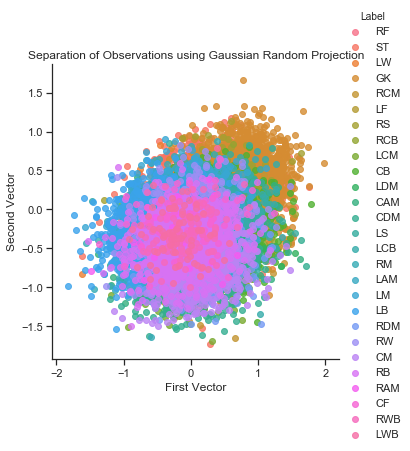

In [137]:
scatterPlot(predictors_scaled_GRP, fifa.Position, "Gaussian Random Projection")

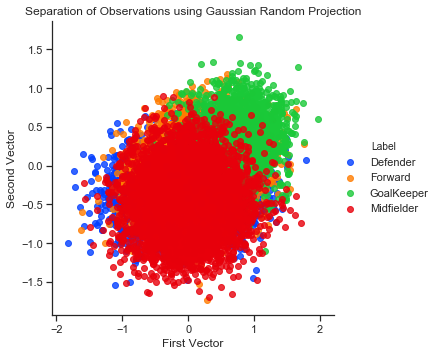

In [138]:
scatterPlot(predictors_scaled_GRP, fifa.Position_Group, "Gaussian Random Projection")

---

## SparseRandomProjection

In [85]:
from sklearn.random_projection import SparseRandomProjection

n_components = 121
density = 'auto'
eps = .01
dense_output = True
random_state = 218

SRP = SparseRandomProjection(n_components=n_components, \
        density=density, eps=eps, dense_output=dense_output, \
                                random_state=random_state)

predictors_SRP = SRP.fit_transform(anomaly_scaled)
predictors_SRP = pd.DataFrame(data=predictors_SRP, index=anomaly_scaled.index)


In [86]:
def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", \
               data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using "+algoName)

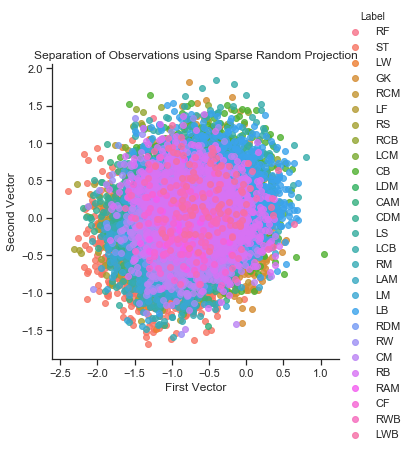

In [87]:
scatterPlot(predictors_SRP, fifa.Position, "Sparse Random Projection")

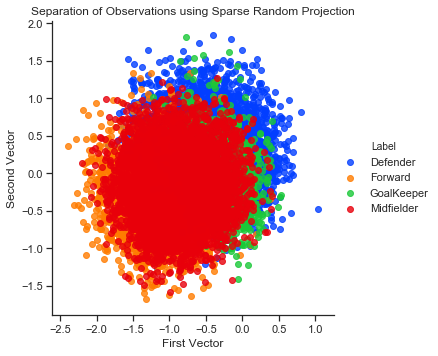

In [88]:
scatterPlot(predictors_SRP, fifa.Position_Group, "Sparse Random Projection")

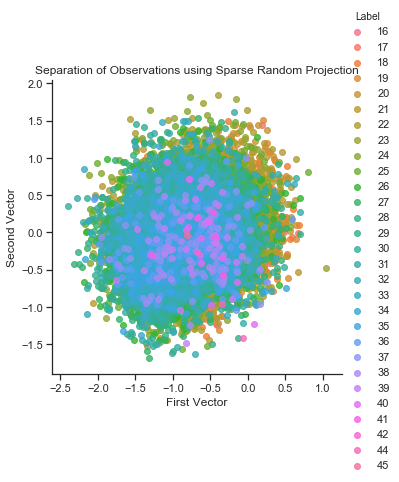

In [89]:
scatterPlot(predictors_SRP, fifa.Age, "Sparse Random Projection")

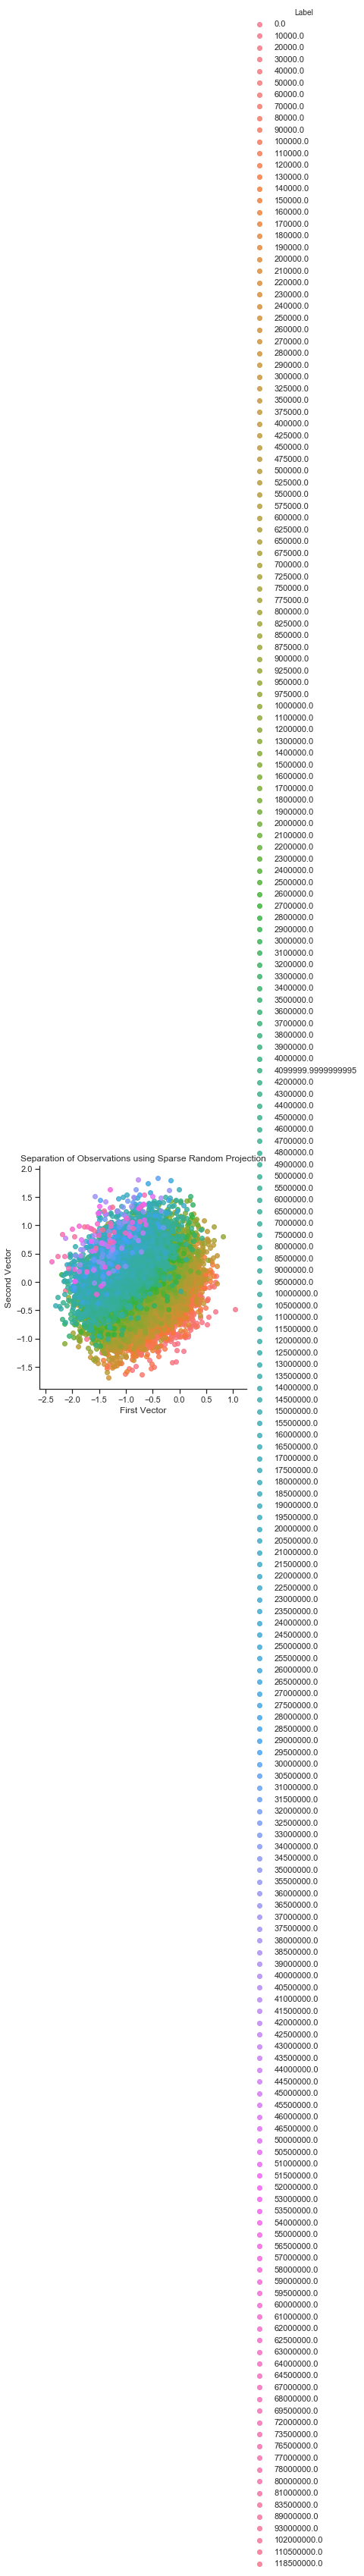

In [90]:
scatterPlot(predictors_SRP, target_val, "Sparse Random Projection")

---

## MiniBatchDictionaryLearning

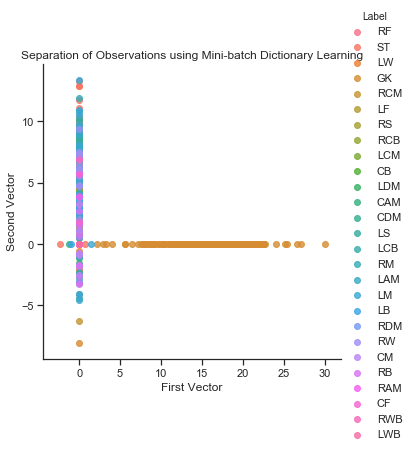

In [91]:
# Mini-batch dictionary learning
from sklearn.decomposition import MiniBatchDictionaryLearning

n_components = 121
alpha = 1
batch_size = 100
n_iter = 10
random_state = 218

miniBatchDictLearning = MiniBatchDictionaryLearning( \
    n_components=n_components, alpha=alpha, batch_size=batch_size, \
    n_iter=n_iter, random_state=random_state)

miniBatchDictLearning.fit(anomaly_scaled)
predictors_scaled_miniBatchDictLearning = \
    miniBatchDictLearning.fit_transform(anomaly_scaled)
predictors_scaled_miniBatchDictLearning = \
    pd.DataFrame(data=predictors_scaled_miniBatchDictLearning, index=anomaly_scaled.index)

scatterPlot(predictors_scaled_miniBatchDictLearning, fifa.Position, \
            "Mini-batch Dictionary Learning")

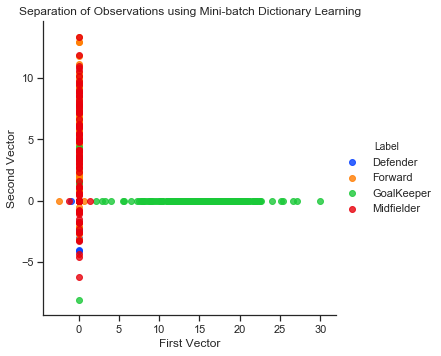

In [92]:
scatterPlot(predictors_scaled_miniBatchDictLearning, fifa.Position_Group, \
            "Mini-batch Dictionary Learning")